# **Acetaminophen Attenuates Perception of Auditory Stimuli**
# ***MODELING***



In [1]:
# basic coding/ML tools
import numpy as np, pandas as pd, os, sys, scipy, xlrd, urllib, pandas_profiling, itertools, re, warnings
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from pandas.api.types import CategoricalDtype
from scipy import stats
from scipy.stats import ttest_ind
from fancyimpute import KNN

# ML tools
import sklearn, statsmodels.api as sm, statsmodels.formula.api as smf, cvxopt, pingouin as pg
from statsmodels.stats.anova import AnovaRM
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from imblearn.over_sampling import SMOTE

# visualization tools
import matplotlib.pyplot as plt, qgrid, seaborn as sns, IPython.display
from statsmodels.graphics.factorplots import interaction_plot
from IPython.display import Image, HTML
from plotnine import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# View tab (Taken from Martin: https://stackoverflow.com/users/2575273/martin)
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))
files = os.listdir(os.curdir)

# set directory
os.chdir("/Users/home/Desktop/Research/Tylenol/Analysis")
print(os.getcwd())

# only get warnings once
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)

# toggle on/off code!
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Using TensorFlow backend.


/Users/home/Desktop/Research/Tylenol/Analysis


In [2]:
inducedLong = pd.read_csv('inducedLong.csv')
perceivedLong = pd.read_csv('perceivedLong.csv')
model = pd.read_csv('model.csv')

# **Regression: Overview**
Now that we have completed feature engineering, we can use linear regression to investigate which features contribute to emotion ratings!

**Of course, we are the most interested in seeing whether those who took the drug give reduced (blunted) ratings, compared to those who took the placebo.**

**We will run a few models:**
1. Predicting *positive* emotion ratings
2. Predicting *negative* emotion ratings
3. Predicting *arousal* ratings
4. Predicting *all* emotion ratings

**For each of these models, we will run a few multiple linear regressions:**
1. Simple OLS model
2. OLS model with lasso regularization to penalize complexity
3. Hierarchical/mixed model (with participant ID as the random effect).
    
    *Using ID as a random effect allows us to account for differences among participants and hence perform a within-subjects analysis.*

# **Regression: Predicting Positive Emotion Ratings**

We do not want every single column in these regression models. 

**The variables we do not need are the following:**
* Negative emotion atings and arousal ratings -- we are only focused on positive emotion ratings here.
* Specific stimulus names -- the features of each stimulus are encoded as Locus (perceived/induced), SoundType (music, speech, natural sounds), HighLow (arousal) and PosNeg (valence).
* Specific emotions -- these will be used in a separate analysis later on.

We also want to rename the Positive column to Ratings. This will allow us to combine the positive, negative, and arousal dataframes later on.

In [3]:
emotions = list(model.loc[:, 'Anger':'Neutral'].columns)

colList = list(model.columns)
colList = [i for i in colList if i not in ('Negative', 'Arousal')]
colList = [i for i in colList if i[:8] != 'Stimulus']
colList = [i for i in colList if i not in emotions]
    
positive = model[colList]
positive = positive.rename(columns={"Positive": "Ratings"})

print("entire dataframe shape: ", model.shape)
print("positive dataframe shape: ", positive.shape)

entire dataframe shape:  (13218, 139)
positive dataframe shape:  (13218, 77)


#### *X and Y*
* Y variable -- *Ratings*
* X variables -- *All other columns except FixedID (the random effect measured later)*

In [4]:
colList = list(positive.columns)
colList = [i for i in colList if i not in ('FixedID', 'Ratings')]

y = positive['Ratings']

X = positive[colList]
X = sm.add_constant(X)
View(pd.DataFrame(X.dtypes))

#### *OLS regression*
Note that interactions are already taken care of through the one-hot encoding

In [5]:
olsresult = sm.OLS(y, X).fit()
print(olsresult.summary())

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     226.5
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:40:32   Log-Likelihood:                -29848.
No. Observations:               13218   AIC:                         5.984e+04
Df Residuals:                   13147   BIC:                         6.037e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

#### Conclusions:
* **The measured variables explain 54% of the variance in positive emotion ratings (adjusted R^2 = 0.54)**
* **The ingestion of acetaminophen blunted ratings of positive emotions compared to the ingestion of a placebo.**

|	Name	|	Coefficient	|	p	|	Interpretation	|
|	------	|	------	|	------	|	------	|
| 	***DrugPlacebo***	| 	***-0.2338***	| 	***0***	| 	*Those who **took acetaminophen** rated positive emotions as **less intense** than those who took the placebo.* ***Namely, acetaminophen blunted the emotional responses.***	| 
| 	PosNeg_Positive	| 	2.9338	| 	0	| 	**Positively-valenced stimuli** resulted in comparatively **high** positive emotion ratings.	| 
| 	PosNeg_Negative	| 	-1.8991	| 	0	| 	**Negatively-valenced stimuli** resulted in comparatively **low** positive emotion ratings.	| 
| 	HighLow_High	| 	0.8216	| 	0	| 	Stimuli that exhibit **high arousal** resulted in comparatively **more intense** positive emotion ratings.	| 
| 	SoundType_Music	| 	0.7015	| 	0	| 	**Musical stimuli** resulted in comparatively **higher ratings of** positive emotion.	| 
| 	Familiarity	| 	0.4672	| 	0	| 	Those who are more **familiar** with the (musical) stimuli rated positive emotions as **more intense.**	| 
| 	A	| 	0.2752	| 	0	| 	Those who are more **agreeable** rated emotions as relatively **more positive** than those who score less high on this personality dimension.	| 
| 	PD	| 	0.2485	| 	0	| 	Those who score higher on the **Personal Distress component of empathy** rated emotions as relatively **more positive** than those who score less high on this trait.	| 
| 	FS	| 	-0.1584	| 	0	| 	Those who score higher on the **Fantasy component of empathy** rated emotions as relatively **less positive** than those who score less high on this trait.	| 
| 	Locus	| 	-0.1575	| 	0.001	| 	Compared to perceived emotion ratings, **induced emotion ratings** were **more positive**.	| 
| 	N	| 	-0.1498	| 	0	| 	Those who are more **neurotic** rated emotions as relatively **less positive** than those who score less high on this personality dimension.	| 
| 	Intense	| 	-0.1285	| 	0	| 	Those who **prefer "Intense" music** (Rock, Punk, Alternative, Heavy Metal) rated emotions as relatively **less positive** (broadly, in response to all stimuli) than those who do not like this genre of music.	| 
| 	E	| 	0.1282	| 	0	| 	Those who are more **extraverted** rated emotions as relatively **more positive** than those who score less high on this personality dimension.	| 
| 	Sophisticated	| 	0.1144	| 	0	| 	Those who **prefer "Sophisticated" music** (Blues, Jazz, Bluegrass, Folk, Classical, Gospel, Opera) rated emotions as relatively **more positive** (broadly, in response to all stimuli) than those who do not like this genre of music.	| 
| 	Nostalgia	| 	-0.0659	| 	0.001	| 	Those who scored high on **nostalgia** rated relatively **less intense** positive ratings (although this effect is small).	|



#### *OLS regression with lasso regularization*
There's no way to look at standard errors, p-values, R^2, etc. because the theory for these values is still being developed among statisticians.

In [6]:
lassomodel = sm.OLS(y, X)
lassoresult = lassomodel.fit_regularized('elastic_net', L1_wt = 1.0) 
    # L1_wt = 0.0 -- ridge (to 1.0 -- lasso)
View(pd.DataFrame(lassoresult.params))

#### Conclusions:
* **This didn't change very much from the original mode.**
* **This chart shows the "non-zero" variables from the original OLS --> these are the only (significant) features kept in the regularized model**
* **Note that I used an arbitrary cutoff of 0.1 coefficient value to count as significant.**

|	Features Remaining In the Model	|	OLS Coefficient	|	OLS **with lasso regularization** Coefficient	|
|	------	|	------	|	------	|
| 	***DrugPlacebo***	| 	***-0.2338***	| 	***-0.213441***	| 
| 	PosNeg_Positive	| 	2.9338	| 	2.679953	| 
| 	PosNeg_Negative	| 	-1.8991	| 	-2.152853	| 
| 	PosNeg_Neutral	| 	-0.3592	| 	-1.489466	| 
| 	Race_Other	| 	-0.7092	| 	-0.566435	| 
| 	Familiarity	| 	0.4672	| 	0.4724	| 
| 	PoliticalParty_other	| 	-1.0292	| 	-0.439776	| 
| 	SoundType_Music	| 	0.7015	| 	0.410356	| 
| 	Race_Asian	| 	0.3401	| 	0.401408	| 
| 	PoliticalParty_republican	| 	-0.8987	| 	-0.343314	| 
| 	HighLow_High	| 	0.8216	| 	0.304188	| 
| 	PreferredMeds_Other	| 	-0.9656	| 	-0.270893	| 
| 	Gender_male	| 	0.8519	| 	-0.262979	| 
| 	PD	| 	0.2485	| 	0.238791	| 
| 	TakeMedsRecentlyYN	| 	-0.1649	| 	-0.189407	| 
| 	Gender_female	| 	1.0504	| 	-0.179473	| 
| 	PreferredMeds_Acetaminophen	| 	-0.5405	| 	0.159463	| 
| 	Locus	| 	-0.1575	| 	-0.154902	| 
| 	PreferredMeds_Do Not Take Meds	| 	-0.7738	| 	-0.139533	| 
| 	N	| 	-0.1498	| 	-0.137826	| 
| 	FS	| 	-0.1584	| 	-0.134634	| 
| 	PoliticalParty_democrat	| 	-0.7095	| 	-0.124515	| 
| 	Intense	| 	-0.1285	| 	-0.11814	|

#### *Mixed Model*
FixedID (the participant ID numbers) will be used as the grouping variable (the random effect)

In [7]:
# hierarchicalmodel = sm.MixedLM(y, X, positive['FixedID'])
# hierarchicalresult = hierarchicalmodel.fit()
# print(hierarchicalresult.summary())

#### Conclusions:
* **The model did not converge**
* **Basically no features are significant in the mixed model (because they are so redundant with the questionnaire data)**

# **Regression: Predicting Negative Emotion Ratings**

In [8]:
colList = list(model.columns)
colList = [i for i in colList if i not in ('Positive', 'Arousal')]
colList = [i for i in colList if i[:8] != 'Stimulus']
colList = [i for i in colList if i not in emotions]
    
negative = model[colList]
negative = negative.rename(columns={"Negative": "Ratings"})

print("entire dataframe shape: ", model.shape)
print("negative dataframe shape: ", negative.shape)

entire dataframe shape:  (13218, 139)
negative dataframe shape:  (13218, 77)


#### *X and Y*

In [9]:
colList = list(negative.columns)
colList = [i for i in colList if i not in ('FixedID', 'Ratings')]

y = negative['Ratings']

X = negative[colList]
X = sm.add_constant(X)
View(pd.DataFrame(X.dtypes))

#### *OLS regression*

In [10]:
olsresult = sm.OLS(y, X).fit()
print(olsresult.summary())

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     179.0
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:40:34   Log-Likelihood:                -30464.
No. Observations:               13218   AIC:                         6.107e+04
Df Residuals:                   13147   BIC:                         6.160e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

#### Conclusions:
* **The measured variables explain 49% of the variance in negative emotion ratings (adjusted R^2 = 0.49)**
* **The ingestion of acetaminophen blunted ratings of negative emotions compared to the ingestion of a placebo.**

|	Name	|	Coefficient	|	p	|	Interpretation	|
|	------	|	------	|	------	|	------	|
| 	***DrugPlacebo***	| 	***-0.1973***	| 	***0***	| 	*Those who **took acetaminophen** rated negative emotions as **less intense** than those who took the placebo.* ***Namely, acetaminophen blunted the emotional responses.***	| 
| 	PosNeg_Negative	| 	3.229	| 	0	| 	**Negatively-valenced stimuli** resulted in comparatively **high** negative emotion ratings.	| 
| 	PosNeg_Positive	| 	-1.5875	| 	0	| 	**Positively-valenced stimuli** resulted in comparatively **low** negative emotion ratings.	| 
| 	SoundType_Natural Sounds	| 	0.959	| 	0	| 	**Natural Sounds** resulted in comparatively **higher ratings** of negative emotion *(and its effect is comparatively large next to speech and especially compared to music)*	| 
| 	HighLow_High	| 	0.892	| 	0	| 	Stimuli that exhibit **high arousal** resulted in comparatively **more intense** negative emotion ratings.	| 
| 	HighLow_Low	| 	0.7495	| 	0	| 	Stimuli that exhibit **low arousal** resulted in comparatively **higher** negative emotion ratings *(but the effect is smaller than the high arousal music)*.	| 
| 	SoundType_Speech	| 	0.6445	| 	0	| 	**Speech** resulted in comparatively **higher ratings** of negative emotion *(and its effect is comparatively large with musical stimuli)*	| 
| 	SoundType_Music	| 	0.3946	| 	0.004	| 	**Musical stimuli** resulted in comparatively **higher ratings** of negative emotion *(but the effect is small compared to speech and natural sounds)*	| 
| 	Locus	| 	-0.2381	| 	0	| 	Compared to perceived emotion ratings, **induced emotion ratings** were **less negative**.	| 
| 	EC	| 	0.2329	| 	0	| 	Those who score higher on the **Empathic Concern component of empathy** rated emotions as relatively **more negative** than those who score less high on this trait.	| 
| 	PD	| 	0.226	| 	0	| 	Those who score higher on the **Personal Distress component of empathy** rated emotions as relatively **more negative** than those who score less high on this trait.	| 
| 	Intense	| 	-0.1078	| 	0	| 	Those who **prefer "Intense" music** (Rock, Punk, Alternative, Heavy Metal) rated emotions as relatively **less negative** (broadly, in response to all stimuli) than those who do not like this genre of music.	| 
| 	Unpretentious	| 	-0.0967	| 	0.001	| 	Those who **prefer "Unpretentious" music** (Pop, Country, Religious) rated emotions as relatively **less negative** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	| 
| 	N	| 	-0.0835	| 	0.047	| 	Those who are more **neurotic** rated emotions as relatively **more negative** than those who score less high on this personality dimension (although this effect is small).	| 
| 	Mellow	| 	0.0769	| 	0.007	| 	Those who **prefer "Mellow" music** (Dance/Electronica, New Age, World) rated emotions as relatively **more negative** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	| 
| 	Nostalgia	| 	-0.0428	| 	0.041	| 	Those who scored high on **nostalgia** rated relatively **less intense** negative ratings (although this effect is small).	|

#### *OLS regression with lasso regularization*

In [11]:
lassomodel = sm.OLS(y, X)
lassoresult = lassomodel.fit_regularized('elastic_net', L1_wt = 1.0) 
View(pd.DataFrame(lassoresult.params))

#### Conclusions:
* **This didn't change very much from the original mode.**
* **This chart shows the "non-zero" variables from the original OLS --> these are the only (significant) features kept in the regularized model**
* **Note that I used an arbitrary cutoff of 0.1 coefficient value to count as significant.**

|	Features Remaining In the Model	|	OLS Coefficient	|	OLS **with lasso regularization** Coefficient	|
|	------	|	------	|	------	|
| 	***DrugPlacebo***	| 	***-0.2338***	| 	***-0.170217***	| 
| 	PosNeg_Negative	| 	-1.8991	| 	2.784016	| 
| 	PosNeg_Positive	| 	2.9338	| 	-2.03266	| 
| 	PreferredMeds_Do Not Take Meds	| 	-0.7738	| 	-0.752959	| 
| 	PoliticalParty_other	| 	-1.0292	| 	-0.588811	| 
| 	Race_Other	| 	-0.7092	| 	-0.56928	| 
| 	PosNeg_Neutral	| 	-0.3592	| 	-0.552684	| 
| 	PoliticalParty_democrat	| 	-0.7095	| 	-0.357943	| 
| 	PoliticalParty_republican	| 	-0.8987	| 	-0.340561	| 
| 	SoundType_Music	| 	0.7015	| 	-0.262282	| 
| 	Race_Asian	| 	0.3401	| 	0.257602	| 
| 	Locus	| 	-0.1575	| 	-0.236797	| 
| 	TakeMedsRecentlyYN	| 	-0.1649	| 	-0.192641	| 
| 	Gender_female	| 	1.0504	| 	0.183484	| 
| 	Gender_male	| 	0.8519	| 	-0.183096	| 
| 	Race_Hispanic	| 	-0.2477	| 	0.172875	| 
| 	PreferredMeds_Other	| 	-0.9656	| 	-0.16225	| 
| 	HowMuchLastEat	| 	0.1088	| 	0.150585	| 
| 	PD	| 	0.2485	| 	0.146022	| 
| 	Intense	| 	-0.1285	| 	-0.119339	| 
| 	PreferredMeds_Acetaminophen	| 	-0.5405	| 	0.117664	| 
| 	WhenLastSick	| 	0.0635	| 	0.094308	| 
| 	N	| 	-0.1498	| 	-0.092503	| 
| 	Politics	| 	0.0839	| 	0.080004	| 
| 	A	| 	0.2752	| 	-0.074981	| 
| 	HighLow_High	| 	0.8216	| 	0.07116	| 
| 	PreferredMeds_Ibuprofen	| 	-0.6816	| 	0.063047	| 
| 	E	| 	0.1282	| 	-0.055616	| 
| 	ChildSES	| 	0.0483	| 	-0.049005	| 
| 	FS	| 	-0.1584	| 	-0.047957	| 
| 	NumDoctorVisits	| 	0.0922	| 	0.047311	| 
| 	Nostalgia	| 	-0.0659	| 	-0.046546	| 
| 	NegPANAS	| 	0.0219	| 	0.033516	| 
| 	AdultSES	| 	-0.0722	| 	0.030117	| 
| 	SleepHours	| 	-0.0782	| 	0.022598	| 
| 	Familiarity	| 	0.4672	| 	0.01509	| 
| 	PosPANAS	| 	0.0083	| 	0.011698	|

#### *Mixed Model*

In [12]:
# hierarchicalmodel = sm.MixedLM(y, X, negative['FixedID'])
# hierarchicalresult = hierarchicalmodel.fit()
# print(hierarchicalresult.summary())

#### Conclusions:
* **The model did not converge**
* **Basically no features are significant in the mixed model (because they are so redundant with the questionnaire data)**

# **Regression: Predicting Arousal Ratings**

In [13]:
colList = list(model.columns)
colList = [i for i in colList if i not in ('Positive', 'Negative')]
colList = [i for i in colList if i[:8] != 'Stimulus']
colList = [i for i in colList if i not in emotions]
    
arousal = model[colList]
arousal = arousal.rename(columns={"Arousal": "Ratings"})
print("arousal dataframe shape: ", arousal.shape)
arousal = arousal.dropna()

print("entire dataframe shape: ", model.shape)
print("arousal dataframe shape: ", arousal.shape)

arousal dataframe shape:  (13218, 77)
entire dataframe shape:  (13218, 139)
arousal dataframe shape:  (8880, 77)


#### *X and Y*
Note that we also delete the ***Locus*** (Perceived or Induced) column because all arousal ratings are related to perceived emotion.

In [14]:
colList = list(arousal.columns)
colList = [i for i in colList if i not in ('FixedID', 'Ratings')]

y = arousal['Ratings']

X = arousal[colList]
X = X.drop(columns=['Locus'])
X = sm.add_constant(X)
View(pd.DataFrame(X.dtypes))

#### *OLS regression*

In [15]:
olsresult = sm.OLS(y, X).fit()
print(olsresult.summary())

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     81.78
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:40:37   Log-Likelihood:                -20454.
No. Observations:                8880   AIC:                         4.105e+04
Df Residuals:                    8810   BIC:                         4.154e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

#### Conclusions:
* **The measured variables explain 39% of the variance in the arousal ratings (adjusted R^2 = 0.39)**
* **There was *no difference* in arousal ratings between those who took acetaminophen and those who took a placebo.**

|	Name	|	Coefficient	|	p	|	Interpretation	|
|	------	|	------	|	------	|	------	|
| 	HighLow_High	| 	2.4821	| 	0	| 	Stimuli that exhibit **high arousal** resulted in comparatively **more energetic** ratings.	| 
| 	PosNeg_Positive	| 	1.2796	| 	0	| 	**Positively-valenced stimuli** resulted in comparatively **high energy** ratings.	| 
| 	SoundType_Natural Sounds	| 	1.122	| 	0	| 	**Natural Sounds** resulted in comparatively **higher energy** ratings *(and its effect is comparatively large next to music and especially compared to speech, which is not significant)*	| 
| 	SoundType_Music	| 	0.748	| 	0	| 	**Musical stimuli** resulted in comparatively **higher energy** ratings *(compared to speech, which was non-significant)*	| 
| 	PosNeg_Negative	| 	0.7421	| 	0	| 	**Negatively-valenced stimuli** resulted in comparatively **higher energy**  ratings.	| 
| 	Familiarity	| 	0.6654	| 	0	| 	Those who are more **familiar** with the (musical) stimuli rated the stimuli as being **higher in energy.**	| 
| 	HighLow_Low	| 	-0.4604	| 	0.006	| 	Stimuli that exhibit **low arousal** resulted in comparatively **lower energy** ratings.	| 
| 	E	| 	0.2895	| 	0	| 	Those who are more **extraverted** rated emotions as relatively **more energetic** than those who score less high on this personality dimension.	| 
| 	C	| 	-0.2885	| 	0	| 	Those who are more **conscientious** rated emotions as relatively **less energetic** than those who score less high on this personality dimension.	| 
| 	PD	| 	0.2692	| 	0	| 	Those who score higher on the **Personal Distress component of empathy** rated emotions as relatively **more energetic** than those who score less high on this trait.	| 
| 	EC	| 	0.1969	| 	0.003	| 	Those who score higher on the **Empathic Concern component of empathy** rated emotions as relatively **more energetic** than those who score less high on this trait.	| 
| 	A	| 	0.1713	| 	0.009	| 	Those who are more **agreeable** rated emotions as relatively **more energetic** than those who score less high on this personality dimension.	| 
| 	FS	| 	-0.1671	| 	0.001	| 	Those who score higher on the **Fantasy component of empathy** rated emotions as relatively **less energetic** than those who score less high on this trait.	| 
| 	Unpretentious	| 	-0.1594	| 	0	| 	Those who **prefer "Unpretentious" music** (Pop, Country, Religious) rated emotions as relatively **less energetic** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	| 
| 	Contemporary	| 	0.1279	| 	0	| 	Those who **prefer "Contemporary" music** (Rap/Hip Hop, Soul/R&B, Funk, Reggae) rated emotions as relatively **more energetic** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	| 
| 	Sophisticated	| 	0.1047	| 	0.003	| 	Those who **prefer "Sophisticated" music** (Blues, Jazz, Bluegrass, Folk, Classical, Gospel, Opera) rated emotions as relatively **more energetic** (broadly, in response to all stimuli) than those who do not like this genre of music.	| 
| 	Nostalgia	| 	-0.0533	| 	0.037	| 	Those who scored high on **nostalgia** rated the stimuli aas being relatively **less energetic** than those who score low on this trait (although this effect is small).	|

#### *OLS regression with lasso regularization*

In [16]:
lassomodel = sm.OLS(y, X)
lassoresult = lassomodel.fit_regularized('elastic_net', L1_wt = 1.0) 
View(pd.DataFrame(lassoresult.params))

#### Conclusions:
* **This didn't change very much from the original mode.**
* **This chart shows the "non-zero" variables from the original OLS --> these are the only (significant) features kept in the regularized model**
* **Note that I used an arbitrary cutoff of 0.1 coefficient value to count as significant.**

|	Features Remaining In the Model	|	OLS Coefficient	|	OLS **with lasso regularization** Coefficient	|
|	------	|	------	|	------	|
| 	PosNeg_Neutral	| 	-0.3712	| 	-2.166824	| 
| 	HighLow_High	| 	2.4821	| 	1.47148	| 
| 	HighLow_Low	| 	-0.4604	| 	-1.47148	| 
| 	PosNeg_Positive	| 	1.2796	| 	0.865751	| 
| 	Familiarity	| 	0.6654	| 	0.686584	| 
| 	Race_Black	| 	0.5499	| 	0.609665	| 
| 	SoundType_Natural Sounds	| 	1.122	| 	0.589999	| 
| 	PoliticalParty_other	| 	-1.5415	| 	-0.542389	| 
| 	Gender_male	| 	1.01	| 	-0.517634	| 
| 	PreferredMeds_Do Not Take Meds	| 	-1.4631	| 	-0.470649	| 
| 	ArthritisYN	| 	0.3384	| 	0.393543	| 
| 	Gender_female	| 	1.1362	| 	-0.362125	| 
| 	PoliticalParty_libertarian	| 	-0.485	| 	0.351171	| 
| 	Race_Asian	| 	0.3715	| 	0.343275	| 
| 	PosNeg_Negative	| 	0.7421	| 	0.328635	| 
| 	PoliticalParty_republican	| 	-1.212	| 	-0.32835	| 
| 	PoliticalParty_democrat	| 	-1.203	| 	-0.315477	| 
| 	C	| 	-0.2885	| 	-0.312441	| 
| 	EC	| 	0.1969	| 	0.251219	| 
| 	PreferredMeds_Acetaminophen	| 	-0.7674	| 	0.217798	| 
| 	PreferredMeds_Other	| 	-1.2053	| 	-0.213326	| 
| 	SoundType_Music	| 	0.748	| 	0.208025	| 
| 	HowMuchLastEat	| 	0.1787	| 	0.201207	| 
| 	A	| 	0.1713	| 	-0.193694	| 
| 	FS	| 	-0.1671	| 	-0.180844	| 
| 	EarlyFamilyEnvironment	| 	-0.0971	| 	-0.172594	| 
| 	PD	| 	0.2692	| 	0.154598	| 
| 	AlcoholAvg	| 	0.1291	| 	0.144398	| 
| 	Unpretentious	| 	-0.1594	| 	-0.127286	| 
| 	E	| 	0.2895	| 	0.124883	| 
| 	Sophisticated	| 	0.1047	| 	0.105058	|

#### *Mixed Model*

In [17]:
# hierarchicalmodel = sm.MixedLM(y, X, arousal['FixedID'])
# hierarchicalresult = hierarchicalmodel.fit()
# print(hierarchicalresult.summary())

#### Conclusions:
* **The model did not converge**
* **Basically no features are significant in the mixed model (because they are so redundant with the questionnaire data)**

# **Regression: Predicting All Ratings**

Here, we combine the *positive*, *negative*, and *arousal* dataframes into a single dataframe.

In [18]:
# add column about rating types
positive['RatingType'] = "Positive"
negative['RatingType'] = "Negative"
arousal['RatingType'] = "Arousal"

# check shapes
print("positive shape:", positive.shape)
print("negative shape:", negative.shape)
print("arousal shape:", arousal.shape, "\n")

# make sure column names are the same
print("pos/neg colnames: ", positive.columns == negative.columns, "\n")
print("pos/ar colnames: ", positive.columns == arousal.columns, "\n")
print("ar/neg colnames: ", arousal.columns == negative.columns, "\n")

# rbind
alldata = pd.concat([positive, negative, arousal])
print("alldata shape:", alldata.shape)

# dummify RatingType
alldata = pd.get_dummies(alldata, columns=['RatingType'])

positive shape: (13218, 78)
negative shape: (13218, 78)
arousal shape: (8880, 78) 

pos/neg colnames:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True] 

pos/ar colnames:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True

In [19]:
alldata.to_csv('all_data_long_final.csv', index=False)

#### *X and Y*

In [82]:
colList = list(alldata.columns)
colList = [i for i in colList if i not in ('FixedID', 'Ratings')]

y = alldata['Ratings']

X = alldata[colList]
X = sm.add_constant(X)
View(pd.DataFrame(X.dtypes))

#### *OLS regression*

In [83]:
olsresult = sm.OLS(y, X).fit()
print(olsresult.summary())

                            OLS Regression Results                            
Dep. Variable:                Ratings   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     50.46
Date:                Sun, 24 May 2020   Prob (F-statistic):               0.00
Time:                        14:31:03   Log-Likelihood:                -91076.
No. Observations:               35316   AIC:                         1.823e+05
Df Residuals:                   35243   BIC:                         1.829e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

#### Conclusions:
* **The measured variables explain 9% of the variance in overall emotion ratings (adjusted R^2 = 0.09)**
* **The ingestion of acetaminophen--overall--blunted ratings of positive emotions compared to the ingestion of a placebo.**
* **The low variance explained means that people used there is little similarities in how people used the three types of scales (positive emotions, negative emotions, and arousal).** 
* **It's likely that there's effects going in opposite directions--for example, people use the opposite criteria to judge positive and negative emotion ratings--so it makes sense the R^2 is much closer to 0.**
* **The order of the features (in terms of absolute values of the coefficients) is very similar to the order that they are entered into the equation during the regression. This hints that the feature importances can't be determined reliably.**

|	Name	|	Coefficient	|	p	|	Interpretation	|
|	------	|	------	|	------	|	------	|
| 	***DrugPlacebo***		***-0.1878***		***0***	| 	*Those who **took acetaminophen** rated emotions as **lower overall** compared to those who took the placebo.* ***Namely, acetaminophen blunted the emotional responses.***	| 
|	HighLow_High	|	1.2057	|	0	|	Stimuli that exhibit **high arousal** resulted in comparatively **higher overall ratings**.	|
|	RatingType_Arousal	|	0.8362	|	0	|	**Arousal ratings** were overall comparatively high in number (compared to positive and negative emotion ratings).	|
|	PosNeg_Positive	|	0.7715	|	0	|	**Positively-valenced stimuli** resulted in comparatively **higher overall ratings**.	|
|	PosNeg_Negative	|	0.6284	|	0	|	**Negatively-valenced stimuli** resulted in comparatively **higher overall ratings** (but not as much as positively-valenced stimuli).	|
|	SoundType_Natural Sounds	|	0.6139	|	0	|	**Natural Sounds** resulted in comparatively **higher overall ratings**(compared to music and especially compared to speech, which wasn't significant)*	|
|	SoundType_Music	|	0.5603	|	0	|	**Natural Sounds** resulted in comparatively **higher overall ratings**(compared to speech, which wasn't significant)*	|
|	Locus	|	-0.3237	|	0	|	Compared to perceived emotion ratings, **induced emotion ratings** were **lower in overall score**.	|
|	Familiarity	|	0.3066	|	0	|	Those who are more **familiar** with the (musical) stimuli rated stimuli **comparatively higher overall** compared to people less familiar with the music.	|
|	PD	|	0.2441	|	0	|	Those who score higher on the **Personal Distress component of empathy** rated emotions as relatively **higher overall** than those who score less high on this trait.	|
|	RatingType_Positive	|	0.207	|	0.03	|	**Positive emotion ratings** were overall comparatively high in number (compared to negative ratings).	|
|	HighLow_Low	|	0.1942	|	0.039	|	Stimuli that exhibit **low arousal** resulted in comparatively **high overall ratings** (but the effect is smaller than the high arousal music).	|
|	RatingType_Negative	|	0.1939	|	0.042	|	**Negative emotion ratings** were overall comparatively high in number (but low compared to arousal ratings and positive emotion ratings).	|
|	A	|	0.1491	|	0.001	|	Those who are more **agreeable** rated emotions as relatively **higher overall** than those who score less high on this personality dimension.	|
|	E	|	0.1284	|	0	|	Those who are more **extraverted** rated emotions as relatively **higher overall** than those who score less high on this personality dimension.	|
|	FS	|	-0.1174	|	0	|	Those who score higher on the **Fantasy component of empathy** rated emotions as relatively **lower overall** than those who score less high on this trait.	|
|	EC	|	0.1045	|	0.017	|	Those who score higher on the **Empathic Concern component of empathy** rated emotions as relatively **higher overall** than those who score less high on this trait.	|
|	N	|	-0.0967	|	0.004	|	Those who are more **neurotic** rated emotions as relatively **lower overall** than those who score less high on this personality dimension.	|
|	Unpretentious	|	-0.0901	|	0	|	Those who **prefer "Unpretentious" music** (Pop, Country, Religious) rated emotions as relatively **lower overall** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	|
|	Intense	|	-0.0838	|	0	|	Those who **prefer "Intense" music** (Rock, Punk, Alternative, Heavy Metal) rated emotions as relatively **lower overall** (broadly, in response to all stimuli) than those who do not like this genre of music.	|
|	Sophisticated	|	0.0832	|	0	|	Those who **prefer "Sophisticated" music** (Blues, Jazz, Bluegrass, Folk, Classical, Gospel, Opera) rated emotions as relatively **higher overall** (broadly, in response to all stimuli) than those who do not like this genre of music.	|
|	Contemporary	|	0.0599	|	0.01	|	Those who **prefer "Contemporary" music** (Rap/Hip Hop, Soul/R&B, Funk, Reggae) rated emotions as relatively **higher overall** (broadly, in response to all stimuli) than those who do not like this genre of music (although this effect is small).	|
|	Nostalgia	|	-0.0545	|	0.001	|	Those who scored high on **nostalgia** rated relatively **lower overall** (although this effect is small).	|

#### *OLS regression with lasso regularization*

In [84]:
lassomodel = sm.OLS(y, X)
lassoresult = lassomodel.fit_regularized('elastic_net', L1_wt = 1.0) 
View(pd.DataFrame(lassoresult.params))

#### Conclusions:
* **This didn't change very much from the original mode.**
* **This chart shows the "non-zero" variables from the original OLS --> these are the only (significant) features kept in the regularized model**
* **Note that I used an arbitrary cutoff of 0.1 coefficient value to count as significant.**

|	Features Remaining In the Model	|	OLS Coefficient	|	OLS **with lasso regularization** Coefficient	|
|	------	|	------	|	------	|
| 	***DrugPlacebo***	| 	***-0.1878***	| 	***-0.162255***	| 
| 	RatingType_Arousal	| 	0.8362	| 	0.871276	| 
| 	Gender_prefer not to answer	| 	0.8962	| 	-0.617293	| 
| 	PoliticalParty_other	| 	-1.3326	| 	-0.524402	| 
| 	HighLow_High	| 	1.2057	| 	0.505651	| 
| 	HighLow_Low	| 	0.1942	| 	-0.505651	| 
| 	PosNeg_Positive	| 	0.7715	| 	0.463598	| 
| 	PreferredMeds_Do Not Take Meds	| 	-1.3271	| 	-0.451093	| 
| 	PoliticalParty_republican	| 	-1.1059	| 	-0.343582	| 
| 	Race_Asian	| 	0.2579	| 	0.332973	| 
| 	Locus	| 	-0.3237	| 	-0.322413	| 
| 	PosNeg_Negative	| 	0.6284	| 	0.320646	| 
| 	Familiarity	| 	0.3066	| 	0.317096	| 
| 	ArthritisYN	| 	0.288	| 	0.314295	| 
| 	Gender_male	| 	1.2206	| 	-0.293518	| 
| 	PoliticalParty_democrat	| 	-1.0349	| 	-0.256109	| 
| 	RatingType_Positive	| 	0.207	| 	0.242152	| 
| 	Race_Other	| 	-0.4925	| 	-0.231538	| 
| 	RatingType_Negative	| 	0.1939	| 	0.229102	| 
| 	PreferredMeds_Other	| 	-1.1098	| 	-0.212399	| 
| 	PD	| 	0.2441	| 	0.182542	| 
| 	PoliticalParty_libertarian	| 	-0.5747	| 	0.178751	| 
| 	TakeMedsRecentlyYN	| 	-0.1478	| 	-0.167184	| 
| 	EC	| 	0.1045	| 	0.165425	| 
| 	SoundType_Natural Sounds	| 	0.6139	| 	0.158922	| 
| 	PreferredMeds_Acetaminophen	| 	-0.7306	| 	0.155727	| 
| 	HowMuchLastEat	| 	0.157	| 	0.145694	| 
| 	FS	| 	-0.1174	| 	-0.113215	| 
| 	AlcoholAvg	| 	0.1075	| 	0.106252	| 
| 	SoundType_Music	| 	0.5603	| 	0.10102	|

#### *Mixed Model Regression*

In [85]:
# hierarchicalmodel = sm.MixedLM(y, X, alldata['FixedID'])
# hierarchicalresult = hierarchicalmodel.fit()
# print(hierarchicalresult.summary())

#### Conclusions:
* **The model did not converge --> the matrix was singular**
* **Basically no features are significant in the mixed model (because they are so redundant with the questionnaire data)**

# **Interactions**

### *All Data*
**This is for ALL DATA -- aka perceived and induced, positive, negative, and arousal**

In [86]:
interactionresult = smf.ols(formula = 'Ratings ~ DrugPlacebo + E + A + C + N + O + PT + FS + EC + PD + AIMS + Nostalgia + NeedToBelong + PosPANAS + NegPANAS + (DrugPlacebo * E) + (DrugPlacebo * A) + (DrugPlacebo * C) + (DrugPlacebo * N) + (DrugPlacebo * O) + (DrugPlacebo * PT) + (DrugPlacebo * FS) + (DrugPlacebo * EC) + (DrugPlacebo * PD) + (DrugPlacebo * AIMS) + (DrugPlacebo * Nostalgia) + (DrugPlacebo * NeedToBelong) + (DrugPlacebo * PosPANAS) + (DrugPlacebo * NegPANAS) - 1', data = alldata).fit()
print(interactionresult.summary())

                                 OLS Regression Results                                
Dep. Variable:                Ratings   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              1658.
Date:                Sun, 24 May 2020   Prob (F-statistic):                        0.00
Time:                        14:31:09   Log-Likelihood:                         -92588.
No. Observations:               35316   AIC:                                  1.852e+05
Df Residuals:                   35287   BIC:                                  1.855e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

#### Conclusions:
* **Many of the personality factor interactions ARE significant, but the size of the interaction (beta score) is small**
* **Adjusted R^2 is now 0.576, which is much bigger than the original R^2 (~0.9)**
* *Note: I took out the constant in the formula*

|	Name	|	Coefficient	|	p	|	Interpretation	|
|	------	|	------	|	------	|	------	|
| 	DrugPlacebo:E 	|	0.0959	|	0.066	| 	No interaction between Extraversion and acetaminophen/placebo	| 
| 	***DrugPlacebo:A*** 	|	***-0.3778***	|	***0.000***	| 	 	| 
| 	***DrugPlacebo:C*** 	|	***-0.4526***	|	***0.000***	| 		| 
| 	***DrugPlacebo:N*** 	|	***-0.1972***	|	***0.002***	| 		| 
| 	***DrugPlacebo:O*** 	|	***0.1805***	|	***0.015***	| 		| 
| 	***DrugPlacebo:PT*** 	|	***0.1509***	|	***0.025***	| 		| 
| 	DrugPlacebo:FS	|	-0.0241	|	0.705	| 	No interaction between the Fantasy component of empathy and acetaminophen/placebo	| 
| 	DrugPlacebo:EC	|	0.1418	|	0.071	| 	No interaction between the Empathic Concern component of empathy and acetaminophen/placebo	| 
| 	***DrugPlacebo:PD***	|	***0.1651***	|	***0.019***	| 		| 
| 	DrugPlacebo:AIMS 	|	0.0014	|	0.437	| 	No interaction between the Absorption in Music Scale and acetaminophen/placebo	| 
| 	***DrugPlacebo:Nostalgia*** 	|	***-0.0897***	|	***0.005***	| 		| 
| 	***DrugPlacebo:NeedToBelong*** 	|	***-0.0191***	|	***0.006***	| 		|
| 	***DrugPlacebo:PosPANAS*** 	|	***-0.0134***	|	***0.008***	| 		| 
| 	***DrugPlacebo:NegPANAS*** 	|	***-0.0208***	|	***0.003***	| 		| 

#### *Graph Interactions*

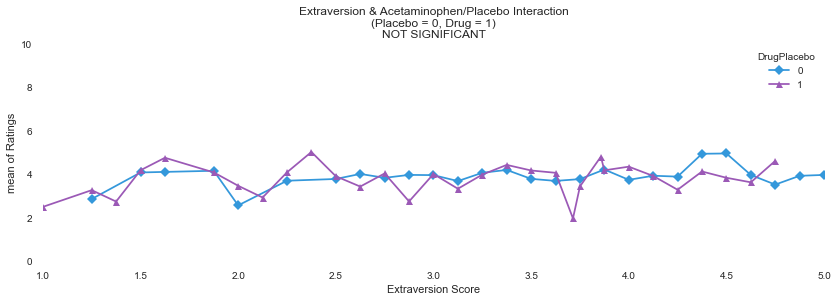

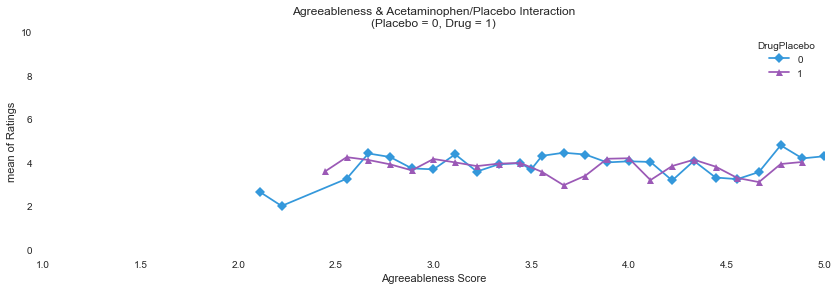

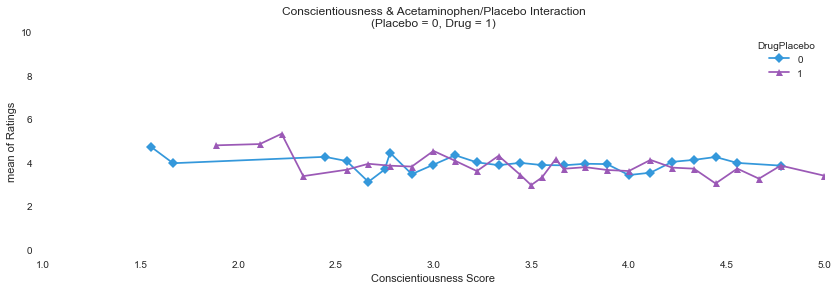

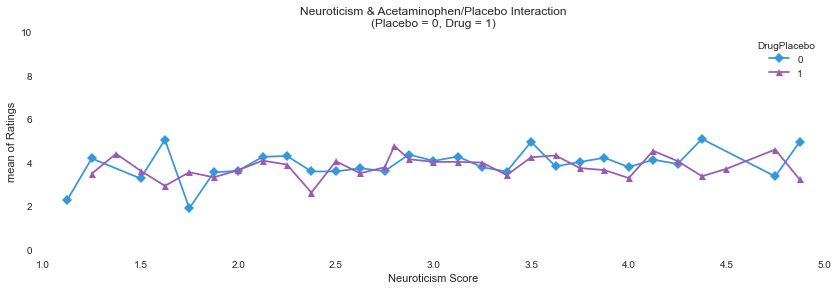

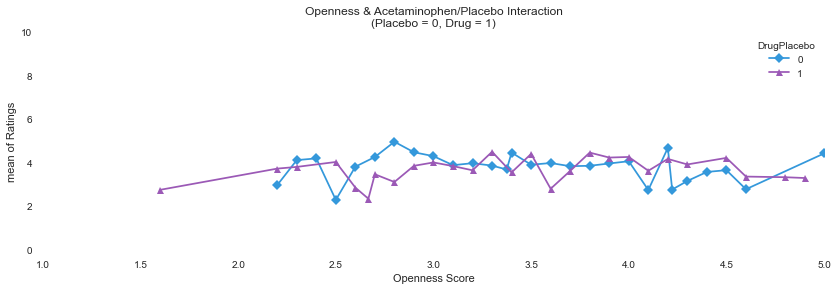

In [87]:
# Personality
E_interaction = interaction_plot(alldata['E'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Extraversion Score')
plt.title('Extraversion & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
A_interaction = interaction_plot(alldata['A'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Agreeableness Score')
plt.title('Agreeableness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
C_interaction = interaction_plot(alldata['C'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Conscientiousness Score')
plt.title('Conscientiousness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
N_interaction = interaction_plot(alldata['N'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Neuroticism Score')
plt.title('Neuroticism & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
O_interaction = interaction_plot(alldata['O'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Openness Score')
plt.title('Openness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

plt.show()

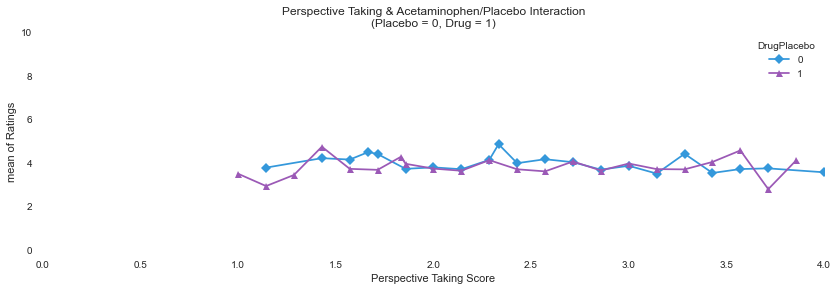

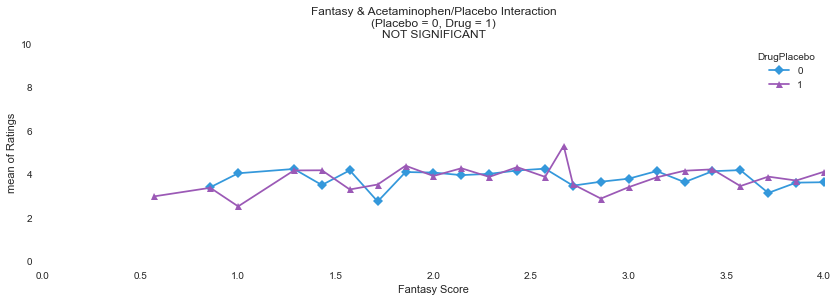

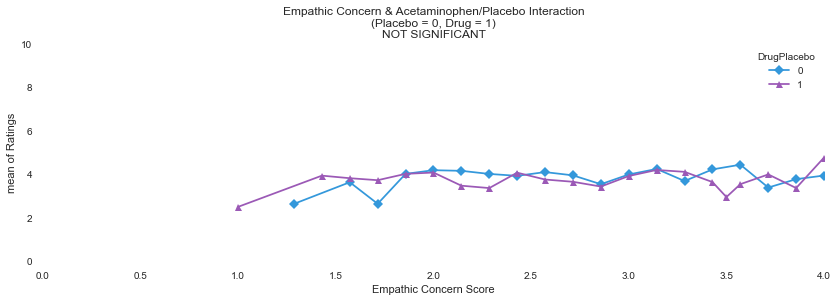

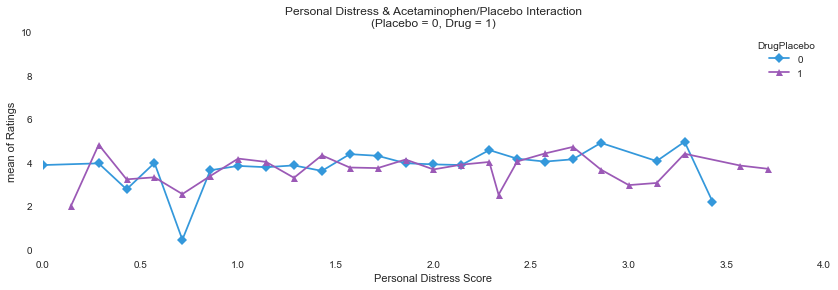

In [88]:
# Empathy 
PT_interaction = interaction_plot(alldata['PT'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Perspective Taking Score')
plt.title('Perspective Taking & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
FS_interaction = interaction_plot(alldata['FS'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Fantasy Score')
plt.title('Fantasy & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
EC_interaction = interaction_plot(alldata['EC'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Empathic Concern Score')
plt.title('Empathic Concern & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
PD_interaction = interaction_plot(alldata['PD'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Personal Distress Score')
plt.title('Personal Distress & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

plt.show()

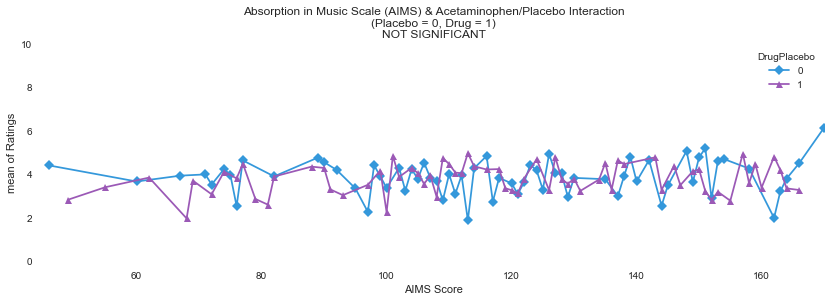

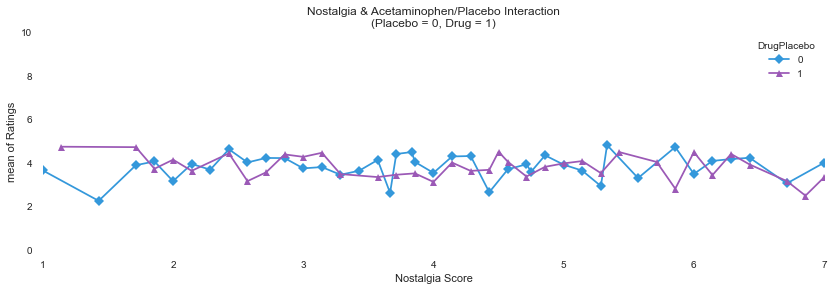

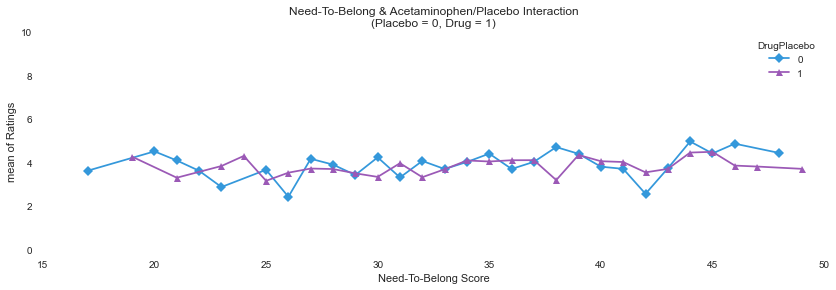

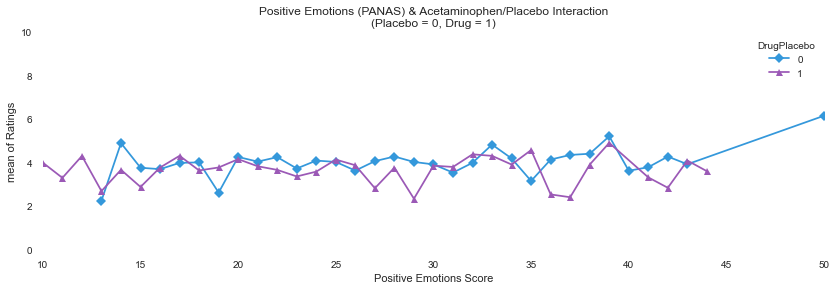

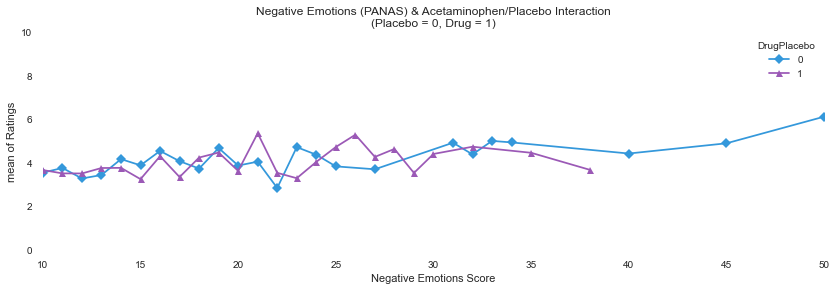

In [89]:
# All Other Interactions
AIMS_interaction = interaction_plot(alldata['AIMS'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='AIMS Score')
plt.title('Absorption in Music Scale (AIMS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(45, 170) 

######################################################################################################
Nostalgia_interaction = interaction_plot(alldata['Nostalgia'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Nostalgia Score')
plt.title('Nostalgia & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 7) 

######################################################################################################
NeedToBelong_interaction = interaction_plot(alldata['NeedToBelong'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Need-To-Belong Score')
plt.title('Need-To-Belong & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(15, 50) 

######################################################################################################
PosPANAS_interaction = interaction_plot(alldata['PosPANAS'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Positive Emotions Score')
plt.title('Positive Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

######################################################################################################
NegPANAS_interaction = interaction_plot(alldata['NegPANAS'], alldata['DrugPlacebo'], alldata['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Negative Emotions Score')
plt.title('Negative Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

plt.show()

### *Perceived*

In [90]:
interactionP = alldata[alldata['Locus'] == 0]
interactionPresult = smf.ols(formula = 'Ratings ~ DrugPlacebo + E + A + C + N + O + PT + FS + EC + PD + AIMS + Nostalgia + NeedToBelong + PosPANAS + NegPANAS + (DrugPlacebo * E) + (DrugPlacebo * A) + (DrugPlacebo * C) + (DrugPlacebo * N) + (DrugPlacebo * O) + (DrugPlacebo * PT) + (DrugPlacebo * FS) + (DrugPlacebo * EC) + (DrugPlacebo * PD) + (DrugPlacebo * AIMS) + (DrugPlacebo * Nostalgia) + (DrugPlacebo * NeedToBelong) + (DrugPlacebo * PosPANAS) + (DrugPlacebo * NegPANAS) - 1', data = interactionP).fit()
print(interactionPresult.summary())

                                 OLS Regression Results                                
Dep. Variable:                Ratings   R-squared (uncentered):                   0.588
Model:                            OLS   Adj. R-squared (uncentered):              0.588
Method:                 Least Squares   F-statistic:                              1310.
Date:                Sun, 24 May 2020   Prob (F-statistic):                        0.00
Time:                        14:31:13   Log-Likelihood:                         -69733.
No. Observations:               26640   AIC:                                  1.395e+05
Df Residuals:                   26611   BIC:                                  1.398e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

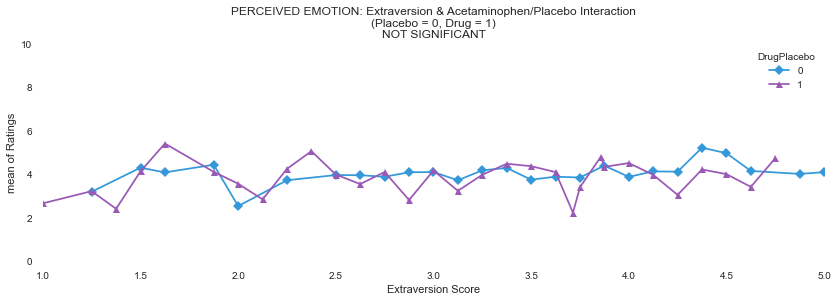

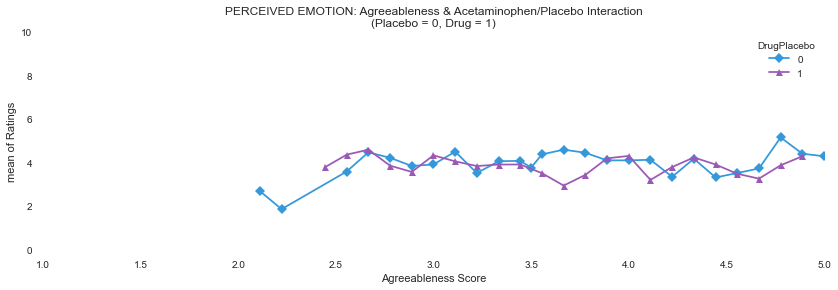

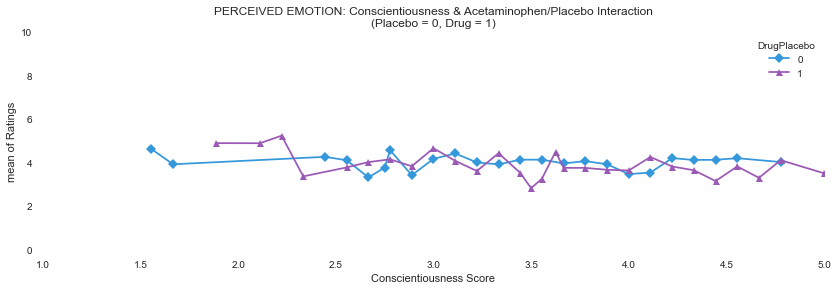

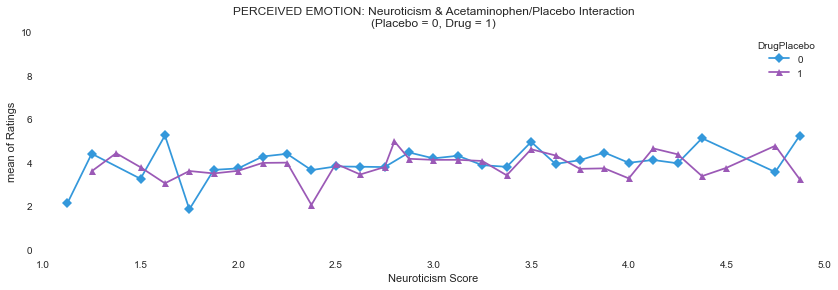

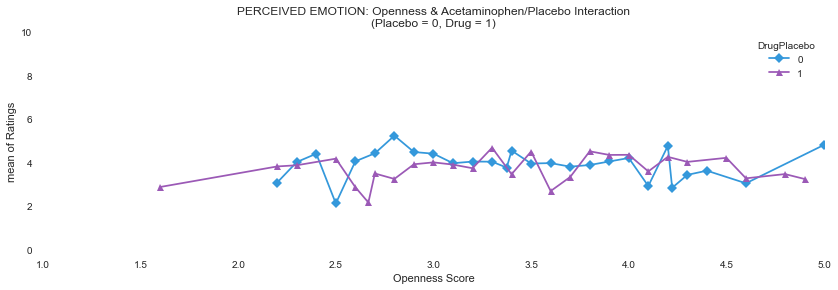

In [91]:
# Personality
E_interaction = interaction_plot(interactionP['E'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Extraversion Score')
plt.title('PERCEIVED EMOTION: Extraversion & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
A_interaction = interaction_plot(interactionP['A'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Agreeableness Score')
plt.title('PERCEIVED EMOTION: Agreeableness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
C_interaction = interaction_plot(interactionP['C'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Conscientiousness Score')
plt.title('PERCEIVED EMOTION: Conscientiousness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
N_interaction = interaction_plot(interactionP['N'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Neuroticism Score')
plt.title('PERCEIVED EMOTION: Neuroticism & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
O_interaction = interaction_plot(interactionP['O'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Openness Score')
plt.title('PERCEIVED EMOTION: Openness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

plt.show()

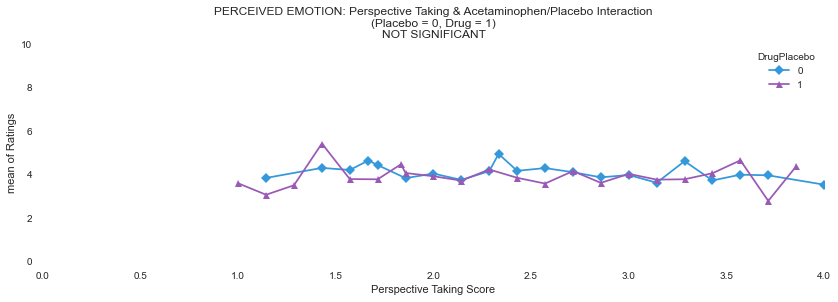

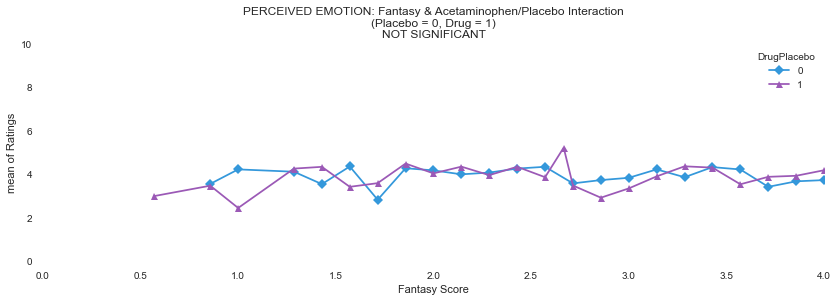

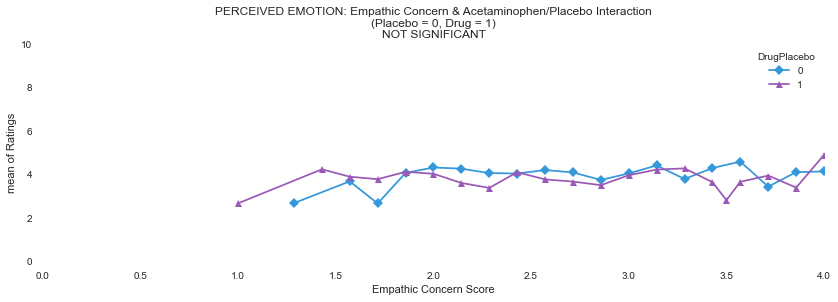

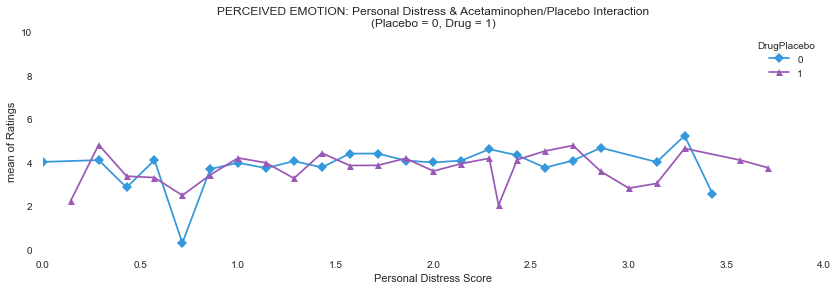

In [92]:
# Empathy 
PT_interaction = interaction_plot(interactionP['PT'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Perspective Taking Score')
plt.title('PERCEIVED EMOTION: Perspective Taking & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
FS_interaction = interaction_plot(interactionP['FS'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Fantasy Score')
plt.title('PERCEIVED EMOTION: Fantasy & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
EC_interaction = interaction_plot(interactionP['EC'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Empathic Concern Score')
plt.title('PERCEIVED EMOTION: Empathic Concern & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
PD_interaction = interaction_plot(interactionP['PD'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Personal Distress Score')
plt.title('PERCEIVED EMOTION: Personal Distress & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

plt.show()

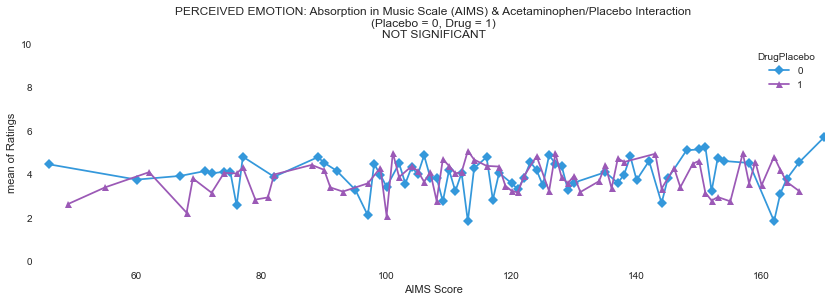

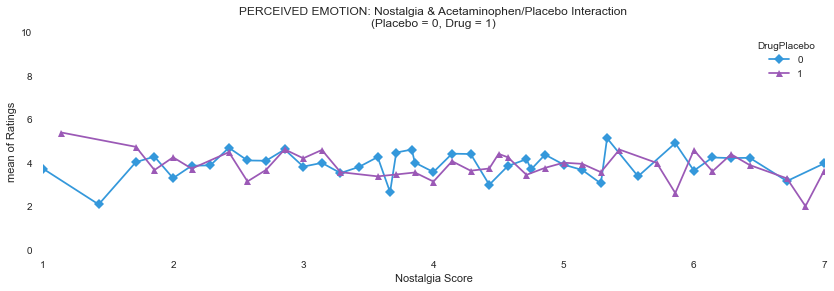

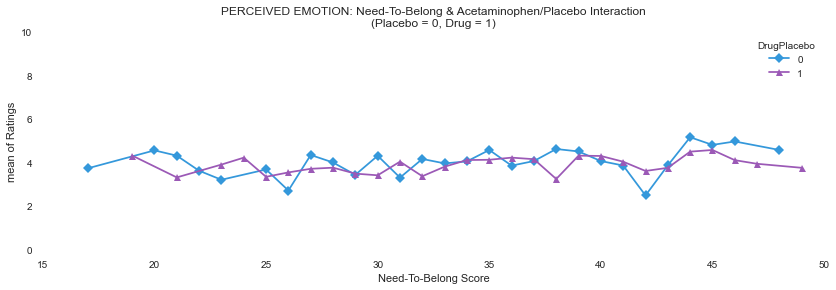

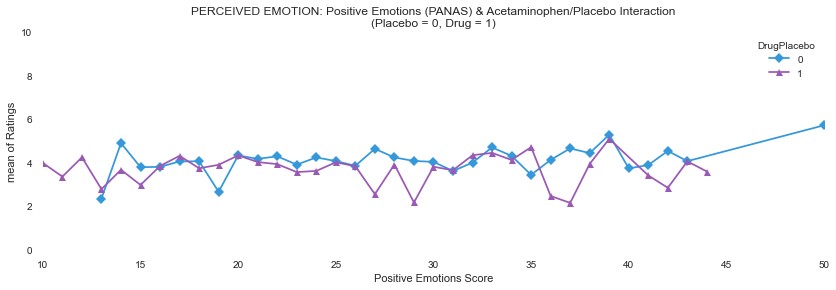

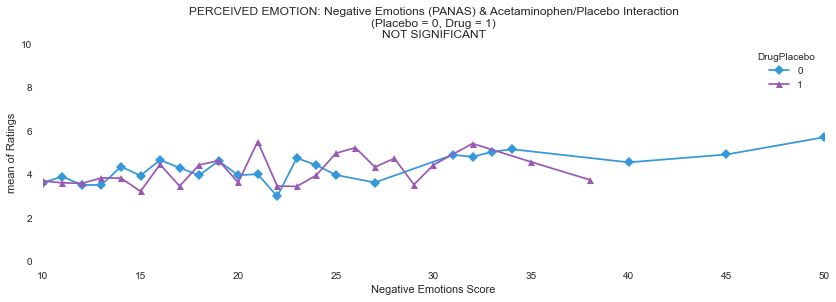

In [93]:
# All Other Interactions
AIMS_interaction = interaction_plot(interactionP['AIMS'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='AIMS Score')
plt.title('PERCEIVED EMOTION: Absorption in Music Scale (AIMS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(45, 170) 

######################################################################################################
Nostalgia_interaction = interaction_plot(interactionP['Nostalgia'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Nostalgia Score')
plt.title('PERCEIVED EMOTION: Nostalgia & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 7) 

######################################################################################################
NeedToBelong_interaction = interaction_plot(interactionP['NeedToBelong'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Need-To-Belong Score')
plt.title('PERCEIVED EMOTION: Need-To-Belong & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(15, 50) 

######################################################################################################
PosPANAS_interaction = interaction_plot(interactionP['PosPANAS'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Positive Emotions Score')
plt.title('PERCEIVED EMOTION: Positive Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

######################################################################################################
NegPANAS_interaction = interaction_plot(interactionP['NegPANAS'], interactionP['DrugPlacebo'], interactionP['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Negative Emotions Score')
plt.title('PERCEIVED EMOTION: Negative Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

plt.show()

### *Induced*

In [94]:
alldata.head(1)

FixedID  DrugPlacebo  Locus  Ratings  Familiarity  MedsEffectiveness  \
0      1.0            0      0      1.0          0.0                4.0   

   LastTimeTookMeds  FrequencyTakeMeds  Politics  ChildSES  AdultSES  Height  \
0            1095.0                1.0       3.0  4.666667       4.0    73.0   

   Weight  SleepHours  WhenLastAte  HowMuchLastEat  SleepQuality  \
0   163.0         5.0     0.666667             2.0           5.0   

   IllnessSeverity  exerciseMinToday  ExerciseRegularMins  \
0              1.0               0.0                360.0   

   LastConsumeCaffeineHours  GeneralHealth  SubjectiveIllness  WhenLastSick  \
0                     0.667            3.0           1.666667           2.0   

   NumDoctorVisits  TakeMedsRecentlyYN  BirthControlYN  MarijuanaFrequency  \
0              0.0                 0.0             0.0                 1.0   

   AlcoholAvg  ArthritisYN   Age  YearUniversity  NeedToBelong  Nostalgia  \
0         0.0          0.0  21.0             3.0          29.0   3.857143   

   EarlyFamilyEnvironment  PosPANAS  NegPANAS  Mellow  Unpretentious  \
0                2.153846      25.0      17.0     5.0            4.0   

   Sophisticated  Intense  Contemporary        PT        FS        EC   PD  \
0       4.285714     4.25          4.25  2.142857  2.142857  1.857143  2.0   

     E         A         C     N    O  AIMS  PosNeg_Negative  PosNeg_Neutral  \
0  3.0  3.111111  3.444444  2.75  3.0  98.0                0               1   

   PosNeg_Positive  HighLow_High  HighLow_Low  HighLow_Neutral  \
0                0             0            0                1   

   SoundType_Music  SoundType_Natural Sounds  SoundType_Speech  Gender_female  \
0                0                         0                 1              0   

   Gender_male  Gender_prefer not to answer  PoliticalParty_democrat  \
0            1                            0                        0   

   PoliticalParty_libertarian  PoliticalParty_other  \
0                           0                     1   

   PoliticalParty_republican  PreferredMeds_Acetaminophen  \
0                          0                            0   

   PreferredMeds_Do Not Take Meds  PreferredMeds_Ibuprofen  \
0                               0                        0   

   PreferredMeds_Other  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                    1           1           0              0           0   

   Race_White  RatingType_Arousal  RatingType_Negative  RatingType_Positive  
0           0                   0                    0                    1

In [95]:
interactionI = alldata[alldata['Locus'] == 1]

# get rid of Arousal ratings
interactionI = alldata[alldata['RatingType_Arousal'] == 0]
interactionIresult = smf.ols(formula = 'Ratings ~ DrugPlacebo + E + A + C + N + O + PT + FS + EC + PD + AIMS + Nostalgia + NeedToBelong + PosPANAS + NegPANAS + (DrugPlacebo * E) + (DrugPlacebo * A) + (DrugPlacebo * C) + (DrugPlacebo * N) + (DrugPlacebo * O) + (DrugPlacebo * PT) + (DrugPlacebo * FS) + (DrugPlacebo * EC) + (DrugPlacebo * PD) + (DrugPlacebo * AIMS) + (DrugPlacebo * Nostalgia) + (DrugPlacebo * NeedToBelong) + (DrugPlacebo * PosPANAS) + (DrugPlacebo * NegPANAS) - 1', data = interactionI).fit()
print(interactionIresult.summary())

                                 OLS Regression Results                                
Dep. Variable:                Ratings   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.545
Method:                 Least Squares   F-statistic:                              1094.
Date:                Sun, 24 May 2020   Prob (F-statistic):                        0.00
Time:                        14:31:19   Log-Likelihood:                         -69813.
No. Observations:               26436   AIC:                                  1.397e+05
Df Residuals:                   26407   BIC:                                  1.399e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

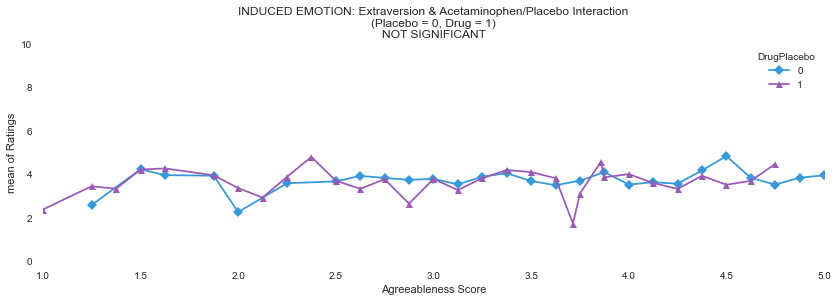

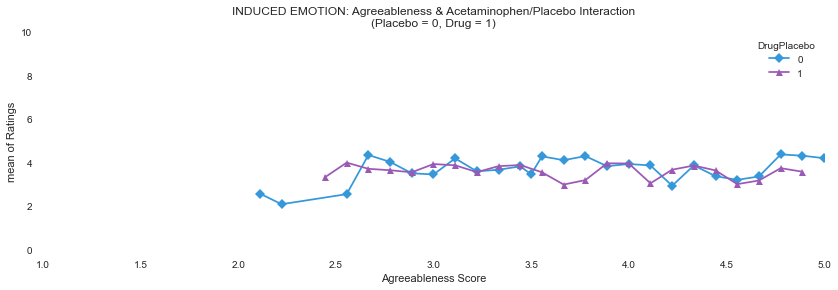

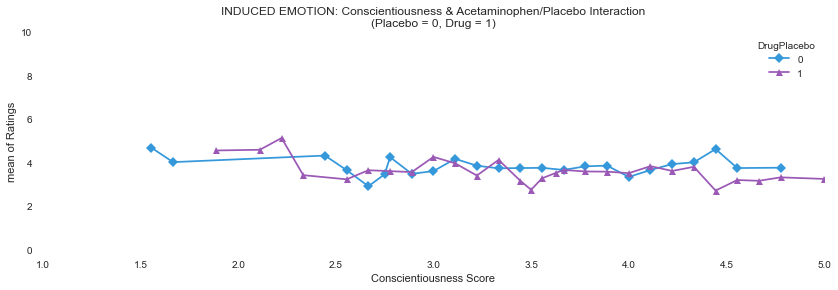

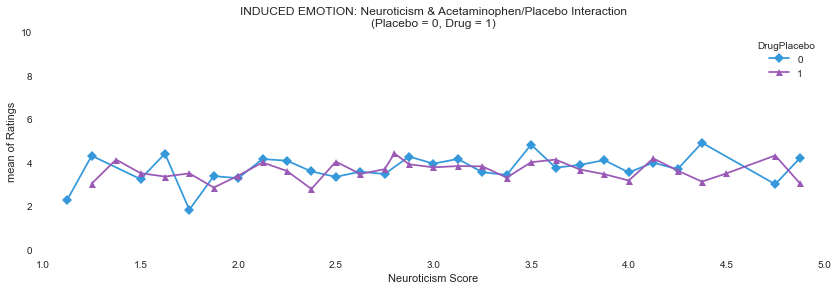

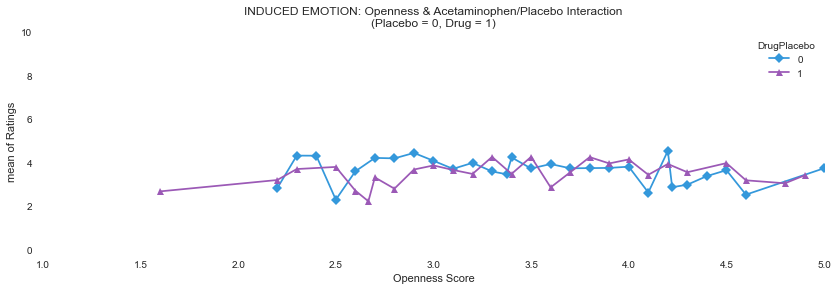

In [96]:
# Personality
E_interaction = interaction_plot(interactionI['E'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"],
                                markers=['D','^'], ylabel='Ratings', xlabel='Agreeableness Score')
plt.title('INDUCED EMOTION: Extraversion & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
A_interaction = interaction_plot(interactionI['A'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Agreeableness Score')
plt.title('INDUCED EMOTION: Agreeableness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
C_interaction = interaction_plot(interactionI['C'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Conscientiousness Score')
plt.title('INDUCED EMOTION: Conscientiousness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
N_interaction = interaction_plot(interactionI['N'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Neuroticism Score')
plt.title('INDUCED EMOTION: Neuroticism & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

######################################################################################################
O_interaction = interaction_plot(interactionI['O'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Openness Score')
plt.title('INDUCED EMOTION: Openness & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 5) 

plt.show()

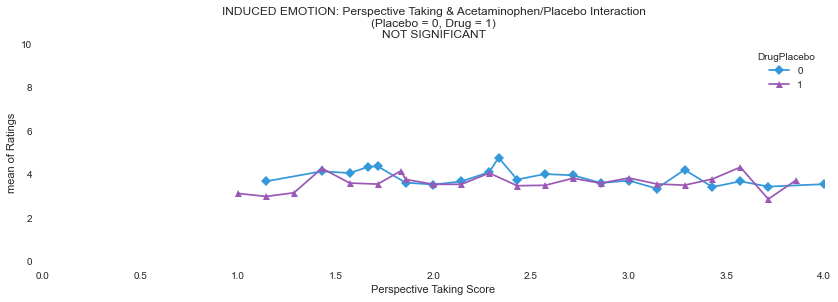

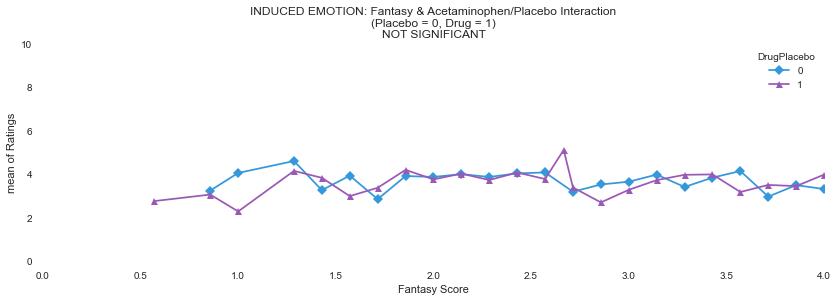

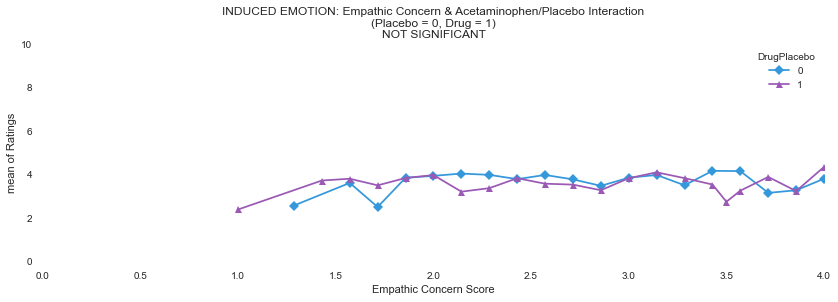

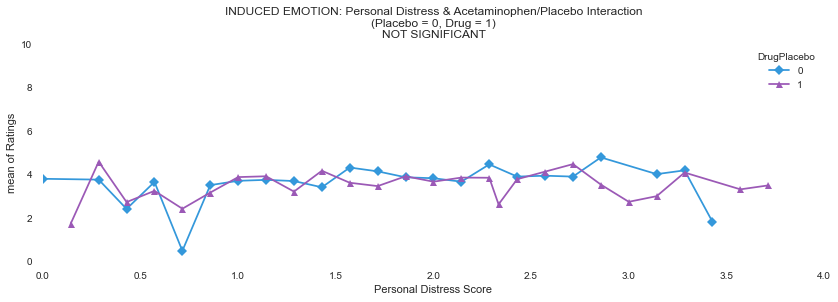

In [97]:
# Empathy 
PT_interaction = interaction_plot(interactionI['PT'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Perspective Taking Score')
plt.title('INDUCED EMOTION: Perspective Taking & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
FS_interaction = interaction_plot(interactionI['FS'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Fantasy Score')
plt.title('INDUCED EMOTION: Fantasy & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
EC_interaction = interaction_plot(interactionI['EC'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Empathic Concern Score')
plt.title('INDUCED EMOTION: Empathic Concern & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

######################################################################################################
PD_interaction = interaction_plot(interactionI['PD'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Personal Distress Score')
plt.title('INDUCED EMOTION: Personal Distress & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(0, 4) 

plt.show()

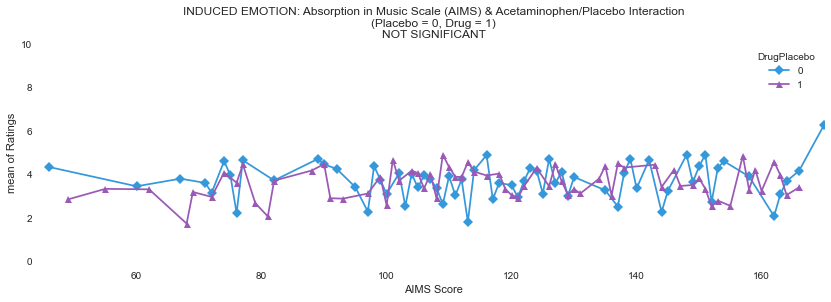

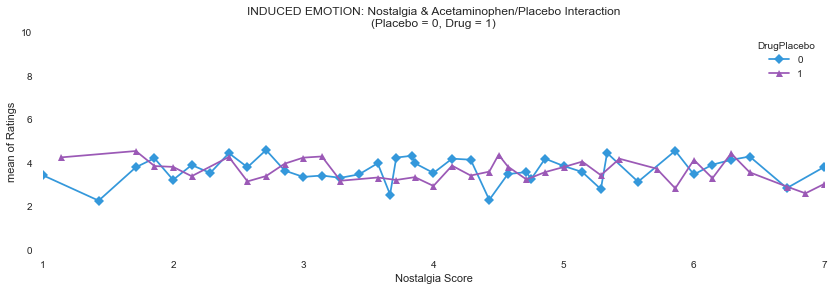

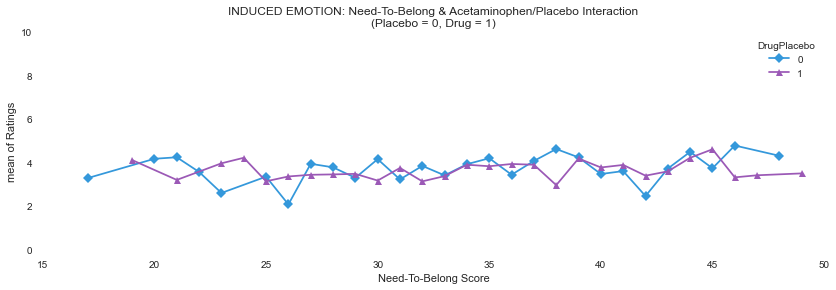

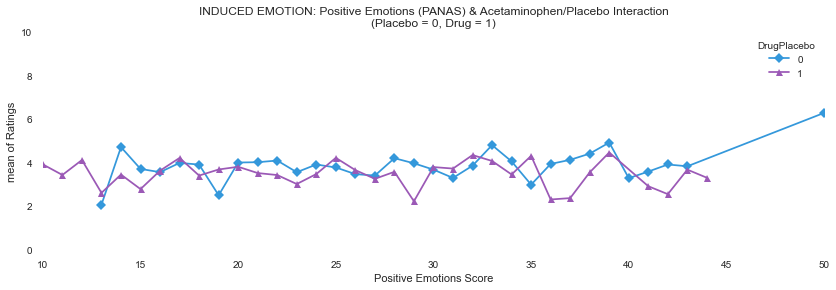

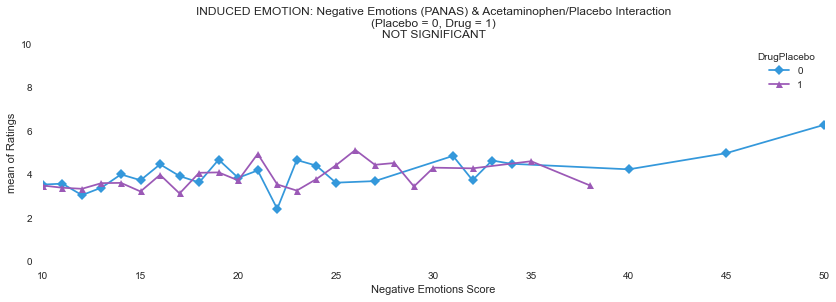

In [98]:
# All Other Interactions
AIMS_interaction = interaction_plot(interactionI['AIMS'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='AIMS Score')
plt.title('INDUCED EMOTION: Absorption in Music Scale (AIMS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(45, 170) 

######################################################################################################
Nostalgia_interaction = interaction_plot(interactionI['Nostalgia'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Nostalgia Score')
plt.title('INDUCED EMOTION: Nostalgia & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(1, 7) 

######################################################################################################
NeedToBelong_interaction = interaction_plot(interactionI['NeedToBelong'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Need-To-Belong Score')
plt.title('INDUCED EMOTION: Need-To-Belong & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(15, 50) 

######################################################################################################
PosPANAS_interaction = interaction_plot(interactionI['PosPANAS'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Positive Emotions Score')
plt.title('INDUCED EMOTION: Positive Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

######################################################################################################
NegPANAS_interaction = interaction_plot(interactionI['NegPANAS'], interactionI['DrugPlacebo'], interactionI['Ratings'], colors=["#3498db", "#9b59b6"], 
                                 markers=['D','^'], ylabel='Ratings', xlabel='Negative Emotions Score')
plt.title('INDUCED EMOTION: Negative Emotions (PANAS) & Acetaminophen/Placebo Interaction\n(Placebo = 0, Drug = 1)\nNOT SIGNIFICANT')
plt.ylim(0, 10) 
plt.xlim(10, 50) 

plt.show()

### ***Conclusions***:
- Many of the personality factor interactions ARE significant, but the size of the interaction (beta score) is small and they are hard to interpret
- Adjusted R^2 is now 0.576, which is much bigger than the original R^2 (~0.9)
- *Note: I took out the constant in the formula*
- *Note: This is for ALL DATA (aka perceived emotion AND induced emotion)*

# **Mixed Model ANOVAs**
**Goal: mixed model anova for specific emotions and valence/arousal**
- We should probably expect no interaction there, suggesting that acetaminophen influences all emotions equally
- Within subjects: ratings for valence/arousal (specific emotions)
- Between subjects: drug/placebo

In [99]:
def soundtype (row):
    if row['SoundType_Music'] == 1 :
        return 'Music'
    if row['SoundType_Natural Sounds'] == 1 :
        return 'Natural Sounds'
    if row['SoundType_Speech'] == 1 :
        return 'Speech'

def ratingtype (row):
    if row['RatingType_Arousal'] == 1 :
        return 'Arousal'
    if row['RatingType_Negative'] == 1 :
        return 'Negative'
    if row['RatingType_Positive'] == 1 :
        return 'Positive'
    
def stimulustype (row):
    if row['PosNeg_Negative'] == 1 and row['HighLow_High'] == 1:
        return 'NV-HA'
    if row['PosNeg_Negative'] == 1 and row['HighLow_Low'] == 1:
        return 'NV-LA'
    if row['PosNeg_Negative'] == 1 and row['HighLow_Neutral'] == 1:
        return 'NV-NeuA'
    if row['PosNeg_Neutral'] == 1 and row['HighLow_High'] == 1:
        return 'NeuV-HA'
    if row['PosNeg_Neutral'] == 1 and row['HighLow_Low'] == 1:
        return 'NeuV-LA'
    if row['PosNeg_Neutral'] == 1 and row['HighLow_Neutral'] == 1:
        return 'NeuV-NeuA'
    if row['PosNeg_Positive'] == 1 and row['HighLow_High'] == 1:
        return 'PV-HA'
    if row['PosNeg_Positive'] == 1 and row['HighLow_Low'] == 1:
        return 'PV-LA'
    if row['PosNeg_Positive'] == 1 and row['HighLow_Neutral'] == 1:
        return 'PV-NeuA'

In [100]:
anova = alldata.loc[:,['FixedID', 'DrugPlacebo', 'Ratings', 'Locus',
                       'PosNeg_Negative', 'PosNeg_Neutral', 'PosNeg_Positive', 
                       'HighLow_High', 'HighLow_Low','HighLow_Neutral', 
                       'SoundType_Music', 'SoundType_Natural Sounds', 'SoundType_Speech',
                       'RatingType_Arousal', 'RatingType_Negative', 'RatingType_Positive']]

### *Perceived Emotion*

In [101]:
perceivedAnova = anova[anova['Locus'] == 0]

perceivedAnova['RatingType'] = perceivedAnova.apply(lambda row: ratingtype(row), axis=1)
perceivedAnova['SoundType'] = perceivedAnova.apply(lambda row: soundtype(row), axis=1)
perceivedAnova['StimulusType'] = perceivedAnova.apply(lambda row: stimulustype(row), axis=1)

perceivedAnova = perceivedAnova.drop(['Locus', 'PosNeg_Negative', 'PosNeg_Neutral', 'PosNeg_Positive', 
                                      'HighLow_High', 'HighLow_Low','HighLow_Neutral', 
                                      'SoundType_Music', 'SoundType_Natural Sounds', 'SoundType_Speech',
                                      'RatingType_Arousal', 'RatingType_Negative', 'RatingType_Positive'], axis=1)

perceivedAnova.head(3)

FixedID  DrugPlacebo  Ratings RatingType       SoundType StimulusType
0      1.0            0      1.0   Positive          Speech    NeuV-NeuA
1      1.0            0      5.0   Positive  Natural Sounds        PV-LA
3      1.0            0      0.0   Positive          Speech        NV-LA

In [102]:
# RatingType
print("PERCEIVED EMOTION")
print("Rating Type: Positive, Negative, Arousal")
ratingtype_ANOVA = pg.mixed_anova(data=perceivedAnova, dv='Ratings', between='DrugPlacebo', 
                                  within='RatingType', subject='FixedID', effsize="np2")

pg.print_table(ratingtype_ANOVA)

PERCEIVED EMOTION
Rating Type: Positive, Negative, Arousal

ANOVA SUMMARY

Source           SS    DF1    DF2      MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
DrugPlacebo   5.837      1    238   5.837   2.334    0.128      nan      0.010  nan           nan        nan        nan
RatingType   64.690      2    476  32.345  73.777    0.000        0.000  0.237    0.973         0.000      0.973      0.037
Interaction   1.679      2    476   0.840   1.915    0.148      nan      0.008  nan           nan        nan        nan



In [103]:
# PosNeg
print("PERCEIVED EMOTION")
print("Rating Type: Only Positive vs Negative (No Arousal)")
posneg = perceivedAnova[perceivedAnova['RatingType'] != "Arousal"]
posneg_ANOVA = pg.mixed_anova(data=posneg, dv='Ratings', between='DrugPlacebo', 
                                  within='RatingType', subject='FixedID', effsize="np2")

pg.print_table(posneg_ANOVA)

PERCEIVED EMOTION
Rating Type: Only Positive vs Negative (No Arousal)

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
DrugPlacebo  6.856      1    238  6.856  4.393    0.037  0.018  nan
RatingType   0.032      1    238  0.032  0.086    0.769  0.000    1.000
Interaction  0.429      1    238  0.429  1.139    0.287  0.005  nan



In [104]:
# StimulusType
print("PERCEIVED EMOTION")
print("Stimulus Type: Negative Valence/Positive Valence/Neutral Valence and High Arousal/Low Arousal/NeutralArousal")
stimulustype_ANOVA = pg.mixed_anova(data=perceivedAnova, dv='Ratings', between='DrugPlacebo', 
                                    within='StimulusType', subject='FixedID', effsize="np2")

pg.print_table(stimulustype_ANOVA) 

PERCEIVED EMOTION
Stimulus Type: Negative Valence/Positive Valence/Neutral Valence and High Arousal/Low Arousal/NeutralArousal

ANOVA SUMMARY

Source              SS    DF1    DF2       MS        F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
------------  --------  -----  -----  -------  -------  -------  -----------  -----  -------  ------------  ---------  ---------
DrugPlacebo      9.984      1    238    9.984    2.293    0.131      nan      0.010  nan           nan        nan        nan
StimulusType  1178.242      4    952  294.561  699.359    0.000        0.000  0.746    0.625         0.000      0.325      0.000
Interaction      0.596      4    952    0.149    0.354    0.842      nan      0.001  nan           nan        nan        nan



In [105]:
# SoundType
print("PERCEIVED EMOTION")
print("Sound Type: Speech, Natural Sounds, and Music")
soundtype_ANOVA = pg.mixed_anova(data=perceivedAnova, dv='Ratings', between='DrugPlacebo', 
                                 within='SoundType', subject='FixedID', effsize="np2")

pg.print_table(soundtype_ANOVA)

PERCEIVED EMOTION
Sound Type: Speech, Natural Sounds, and Music

ANOVA SUMMARY

Source           SS    DF1    DF2      MS        F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -------  -------  -----  -------
DrugPlacebo   5.527      1    238   5.527    2.205    0.139  0.009  nan
SoundType    87.799      2    476  43.900  203.019    0.000  0.460    0.978
Interaction   0.255      2    476   0.127    0.588    0.556  0.002  nan



### *Induced Emotion*

In [106]:
inducedAnova = anova[anova['Locus'] == 0]

inducedAnova['RatingType'] = inducedAnova.apply(lambda row: ratingtype(row), axis=1)
inducedAnova['SoundType'] = inducedAnova.apply(lambda row: soundtype(row), axis=1)
inducedAnova['StimulusType'] = inducedAnova.apply(lambda row: stimulustype(row), axis=1)

inducedAnova = inducedAnova.drop(['Locus', 'PosNeg_Negative', 'PosNeg_Neutral', 'PosNeg_Positive', 
                                      'HighLow_High', 'HighLow_Low','HighLow_Neutral', 
                                      'SoundType_Music', 'SoundType_Natural Sounds', 'SoundType_Speech',
                                      'RatingType_Arousal', 'RatingType_Negative', 'RatingType_Positive'], axis=1)

inducedAnova.head(3)

FixedID  DrugPlacebo  Ratings RatingType       SoundType StimulusType
0      1.0            0      1.0   Positive          Speech    NeuV-NeuA
1      1.0            0      5.0   Positive  Natural Sounds        PV-LA
3      1.0            0      0.0   Positive          Speech        NV-LA

In [107]:
# RatingType
print("INDUCED EMOTION")
print("Rating Type: Positive, Negative (no Arousal ratings in induced emotion)")
ratingtype_ANOVA = pg.mixed_anova(data=inducedAnova, dv='Ratings', between='DrugPlacebo', 
                                  within='RatingType', subject='FixedID', effsize="np2")

pg.print_table(ratingtype_ANOVA)

INDUCED EMOTION
Rating Type: Positive, Negative (no Arousal ratings in induced emotion)

ANOVA SUMMARY

Source           SS    DF1    DF2      MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
DrugPlacebo   5.837      1    238   5.837   2.334    0.128      nan      0.010  nan           nan        nan        nan
RatingType   64.690      2    476  32.345  73.777    0.000        0.000  0.237    0.973         0.000      0.973      0.037
Interaction   1.679      2    476   0.840   1.915    0.148      nan      0.008  nan           nan        nan        nan



In [108]:
# StimulusType
print("INDUCED EMOTION")
print("Stimulus Type: Negative Valence/Positive Valence/Neutral Valence and High Arousal/Low Arousal/NeutralArousal")
stimulustype_ANOVA = pg.mixed_anova(data=perceivedAnova, dv='Ratings', between='DrugPlacebo', 
                                    within='StimulusType', subject='FixedID', effsize="np2")

pg.print_table(stimulustype_ANOVA) 

INDUCED EMOTION
Stimulus Type: Negative Valence/Positive Valence/Neutral Valence and High Arousal/Low Arousal/NeutralArousal

ANOVA SUMMARY

Source              SS    DF1    DF2       MS        F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
------------  --------  -----  -----  -------  -------  -------  -----------  -----  -------  ------------  ---------  ---------
DrugPlacebo      9.984      1    238    9.984    2.293    0.131      nan      0.010  nan           nan        nan        nan
StimulusType  1178.242      4    952  294.561  699.359    0.000        0.000  0.746    0.625         0.000      0.325      0.000
Interaction      0.596      4    952    0.149    0.354    0.842      nan      0.001  nan           nan        nan        nan



In [109]:
# SoundType
print("INDUCED EMOTION")
print("Sound Type: Speech, Natural Sounds, and Music")
soundtype_ANOVA = pg.mixed_anova(data=perceivedAnova, dv='Ratings', between='DrugPlacebo', 
                                 within='SoundType', subject='FixedID', effsize="np2")

pg.print_table(soundtype_ANOVA)

INDUCED EMOTION
Sound Type: Speech, Natural Sounds, and Music

ANOVA SUMMARY

Source           SS    DF1    DF2      MS        F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -------  -------  -----  -------
DrugPlacebo   5.527      1    238   5.527    2.205    0.139  0.009  nan
SoundType    87.799      2    476  43.900  203.019    0.000  0.460    0.978
Interaction   0.255      2    476   0.127    0.588    0.556  0.002  nan



# **Logistic Regression: Predicting Drug vs. Placebo**
In order to use people's ratings to predict whether they were given the drug or a placebo, we have to change the data back to a wide format. 

Namely, there should be one row for each participant.

### Turn one-hot encoded stimuli back into a single column
First, we have to turn all the one-hot encoded values back to a single categorical column.

In [110]:
colList = list(model.columns)
new = model[colList]
print(model.shape)
print(new.shape)

# find instances of where "1" is in a cell in the dataframe
row, col = np.where(new.values == 1)

# replace the column index with the column name
colname = new.columns[col]

# make a dataframe of all these values
vals = pd.DataFrame()
vals['row'] = row
vals['cols'] = colname

(13218, 139)
(13218, 139)


#### *Stimulus*

In [111]:
stimList = list(vals['cols'])
stimList = [i for i in stimList if i[:8] == 'Stimulus']
stim = vals[vals['cols'].isin(stimList)]
stim = stim.set_index('row')
new['Stimulus'] = stim['cols']
new['Stimulus'] = new['Stimulus'].replace(r'^.*Stimulus_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "Stimulus_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *PosNeg*

In [112]:
posnegList = list(vals['cols'])
posnegList = [i for i in posnegList if i[:6] == 'PosNeg']
posneg = vals[vals['cols'].isin(posnegList)]
posneg = posneg.set_index('row')
new['PosNeg'] = posneg['cols']
new['PosNeg'] = new['PosNeg'].replace(r'^.*PosNeg_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "PosNeg_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *HighLow*

In [113]:
highlowList = list(vals['cols'])
highlowList = [i for i in highlowList if i[:7] == 'HighLow']
highlow = vals[vals['cols'].isin(highlowList)]
highlow = highlow.set_index('row')
new['HighLow'] = highlow['cols']
new['HighLow'] = new['HighLow'].replace(r'^.*HighLow_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "HighLow_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *SoundType*

In [114]:
soundtypeList = list(vals['cols'])
soundtypeList = [i for i in soundtypeList if i[:9] == 'SoundType']
soundtype = vals[vals['cols'].isin(soundtypeList)]
soundtype = soundtype.set_index('row')
new['SoundType'] = soundtype['cols']
new['SoundType'] = new['SoundType'].replace(r'^.*SoundType_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "SoundType_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *PoliticalParty*

In [115]:
ppList = list(vals['cols'])
ppList = [i for i in ppList if i[:14] == 'PoliticalParty']
pp = vals[vals['cols'].isin(ppList)]
pp = pp.set_index('row')
new['PoliticalParty'] = pp['cols']
new['PoliticalParty'] = new['PoliticalParty'].replace(r'^.*PoliticalParty_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "PoliticalParty_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *PreferredMeds*

In [116]:
medsList = list(vals['cols'])
medsList = [i for i in medsList if i[:13] == 'PreferredMeds']
meds = vals[vals['cols'].isin(medsList)]
meds = meds.set_index('row')
new['PreferredMeds'] = meds['cols']
new['PreferredMeds'] = new['PreferredMeds'].replace(r'^.*PreferredMeds_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "PreferredMeds_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *Gender*

In [117]:
genderList = list(vals['cols'])
genderList = [i for i in genderList if i[:6] == 'Gender']
gender = vals[vals['cols'].isin(genderList)]
gender = gender.set_index('row')
new['Gender'] = gender['cols']
new['Gender'] = new['Gender'].replace(r'^.*Gender_', '', regex=True)

# delete stimulus one-hot encoded cols
newList = list(new.columns)
newList = [ x for x in newList if "Gender_" not in x ]
new = new[newList]

# reset index
new.reset_index(inplace = True, drop = True) 

#### *Rearrange columns*

In [118]:
new = new.iloc[:, np.r_[0,1,82:86,2:82,86:89]]
print(new.shape)
View(new.head(1).T)

(13218, 89)


### Separate into perceived/induced/questionnaires
We need to separate the three study components (perceived emotion ratings, induced emotion ratings, and questionnaire responses) into separate dataframes.

**Each of these dataframes should have 244 rows--one for each participant.**

#### *Questionnaires*
First, we need to pull out all of the questions from the questionnaires.

In [119]:
wideQ = new.loc[:,'MedsEffectiveness':'Gender']
wideQ['FixedID'] = pd.to_numeric(new['FixedID'])
wideQ['DrugPlacebo'] = new['DrugPlacebo']
wideQ = wideQ.iloc[:, np.r_[55,56,0:55]]
wideQ = wideQ.drop_duplicates()
wideQ = wideQ.sort_values(by=['FixedID'])
wideQ.reset_index(inplace = True, drop = True) 
print("wideQ shape: ", wideQ.shape)

wideQ.head(5)

wideQ shape:  (244, 57)


FixedID  DrugPlacebo  MedsEffectiveness  LastTimeTookMeds  \
0      1.0            0                4.0            1095.0   
1      2.0            1                4.0             365.0   
2      3.0            0                1.0               1.0   
3      4.0            1                1.0            3650.0   
4      5.0            0                5.0             180.0   

   FrequencyTakeMeds  Politics  ChildSES  AdultSES  Height  Weight  \
0                1.0       3.0  4.666667  4.000000    73.0   163.0   
1                4.0       5.0  6.000000  5.333333    69.0   168.0   
2                5.0       3.0  4.333333  2.666667    71.0   145.0   
3                1.0       3.0  5.333333  6.000000    71.0   168.0   
4                4.0       4.0  4.666667  5.666667    72.0   160.0   

   SleepHours  WhenLastAte  HowMuchLastEat  SleepQuality  IllnessSeverity  \
0         5.0     0.666667             2.0           5.0            1.000   
1         8.0     3.000000             3.0           9.0            1.375   
2         8.0     5.000000             2.0           8.0            1.125   
3        10.0     1.000000             3.0           8.0            1.125   
4         5.0     0.500000             1.0           4.0            1.500   

   exerciseMinToday  ExerciseRegularMins  LastConsumeCaffeineHours  \
0               0.0                360.0                     0.667   
1              15.0                300.0                     5.000   
2               0.0                 30.0                   240.000   
3               0.0                270.0                     1.000   
4              30.0                600.0                     1.000   

   GeneralHealth  SubjectiveIllness  WhenLastSick  NumDoctorVisits  \
0            3.0           1.666667           2.0              0.0   
1            4.0           1.333333           4.0              0.0   
2            3.0           1.666667           2.0              1.0   
3            3.0           1.666667           1.0              0.0   
4            5.0           2.000000           5.0              1.0   

   TakeMedsRecentlyYN  BirthControlYN  MarijuanaFrequency  AlcoholAvg  \
0                 0.0             0.0                 1.0    0.000000   
1                 1.0             0.0                 1.0    1.000000   
2                 1.0             0.0                 1.0    0.000000   
3                 0.0             0.0                 7.0    3.000000   
4                 1.0             0.0                 1.0    1.333333   

   ArthritisYN   Age  YearUniversity  NeedToBelong  Nostalgia  \
0          0.0  21.0             3.0          29.0   3.857143   
1          0.0  19.0             2.0          24.0   4.142857   
2          0.0  20.0             2.0          26.0   4.714286   
3          0.0  18.0             1.0          40.0   2.428571   
4          0.0  22.0             2.0          27.0   6.714286   

   EarlyFamilyEnvironment  PosPANAS  NegPANAS    Mellow  Unpretentious  \
0                2.153846      25.0      17.0  5.000000       4.000000   
1                2.923077      35.0      14.0  5.000000       3.666667   
2                2.307692      30.0      15.0  4.666667       3.000000   
3                3.769231      20.0      12.0  3.333333       2.000000   
4                2.692308      42.0      12.0  5.333333       4.333333   

   Sophisticated  Intense  Contemporary        PT        FS        EC  \
0       4.285714     4.25          4.25  2.142857  2.142857  1.857143   
1       3.428571     3.25          5.25  3.142857  1.857143  2.428571   
2       3.714286     6.00          5.00  2.857143  3.000000  2.714286   
3       2.714286     3.75          4.75  2.000000  2.000000  2.571429   
4       4.857143     4.50          6.50  3.285714  2.571429  3.142857   

         PD      E         A         C      N    O   AIMS  Race_Asian  \
0  2.000000  3.000  3.111111  3.444444  2.750  3.0   98.0           1   
1  1.285714  2.750  3.777778  3.

#### *Perceived*
Next, we need to extract all of the perceived emotion information. 

**We ideally want there to be several columns per stimulus. For Fear Music 1, for example:**
* Perceived_Positive_Fear Music 1
* Perceived_Negative_Fear Music 1
* Perceived_Arousal_Fear Music 1
* Perceived_Familiarity_Fear Music 1


In order to create these columns, we need to first stack all of the ratings (positive, negative, arousal, familiarity) on top of each other under a single column: ***Ratings***. That's what is done here.

In [120]:
# positive
p = new[new['Locus'] == 0]
p = p[['FixedID', 'DrugPlacebo', 'Stimulus', 'Positive']]
p['FixedID'] = pd.to_numeric(p['FixedID'])
p['Locus'] = "Perceived"
p['RatingType'] = "Positive"
p = p.rename(columns={"Positive": "Rating"})

# negative
n = new[new['Locus'] == 0]
n = n[['FixedID', 'DrugPlacebo', 'Stimulus', 'Negative']]
n['FixedID'] = pd.to_numeric(n['FixedID'])
n['Locus'] = "Perceived"
n['RatingType'] = "Negative"
n = n.rename(columns={"Negative": "Rating"})

# arousal
a = new[new['Locus'] == 0]
a = a[['FixedID', 'DrugPlacebo', 'Stimulus', 'Arousal']]
a['FixedID'] = pd.to_numeric(a['FixedID'])
a['Locus'] = "Perceived"
a['RatingType'] = "Arousal"
a = a.rename(columns={"Arousal": "Rating"})

# familiarity
f = new[new['Locus'] == 0]
f = f[['FixedID', 'DrugPlacebo', 'Stimulus', 'Familiarity']]
f['FixedID'] = pd.to_numeric(f['FixedID'])
f['Locus'] = "Perceived"
f['RatingType'] = "Familiarity"
f = f.rename(columns={"Familiarity": "Rating"})

# rbind
wideP = pd.concat([p, n, a, f])
wideP = wideP.sort_values(by=['FixedID'])
wideP.reset_index(inplace = True, drop = True) 

print("wideP:", wideP.shape)
wideP.head(5)

wideP: (35520, 6)


FixedID  DrugPlacebo          Stimulus  Rating      Locus   RatingType
0      1.0            0  Neutral Speech 2     1.0  Perceived     Positive
1      1.0            0    Tender Music 5     0.0  Perceived  Familiarity
2      1.0            0     Fear Speech 1     0.0  Perceived  Familiarity
3      1.0            0    Happy Speech 3     0.0  Perceived  Familiarity
4      1.0            0  Neutral Speech 1     0.0  Perceived  Familiarity

#### *Induced*
We repeat the above process for induced emotion. 

*Note that there are no arousal ratings for induced emotion.*

In [121]:
# positive
p = new[new['Locus'] == 1]
p = p[['FixedID', 'DrugPlacebo', 'Stimulus', 'Positive']]
p['FixedID'] = pd.to_numeric(p['FixedID'])
p['Locus'] = "Induced"
p['RatingType'] = "Positive"
p = p.rename(columns={"Positive": "Rating"})

# negatikve
n = new[new['Locus'] == 1]
n = n[['FixedID', 'DrugPlacebo', 'Stimulus', 'Negative']]
n['FixedID'] = pd.to_numeric(n['FixedID'])
n['Locus'] = "Induced"
n['RatingType'] = "Negative"
n = n.rename(columns={"Negative": "Rating"})

# familiarity
f = new[new['Locus'] == 1]
f = f[['FixedID', 'DrugPlacebo', 'Stimulus', 'Familiarity']]
f['FixedID'] = pd.to_numeric(f['FixedID'])
f['Locus'] = "Induced"
f['RatingType'] = "Familiarity"
f = f.rename(columns={"Familiarity": "Rating"})

# rbind
wideI = pd.concat([p, n, f])
wideI = wideI.sort_values(by=['FixedID'])
wideI.reset_index(inplace = True, drop = True) 

print("wideI:", wideI.shape)
wideI.head(5)

wideI: (13014, 6)


FixedID  DrugPlacebo                                 Stimulus  Rating  \
0      1.0            0                             Fear Music 2     2.0   
1      1.0            0                           Tender Music 1     6.0   
2      1.0            0                            Happy Music 2     3.0   
3      1.0            0                            Neutral Human     6.0   
4      1.0            0  Positive-Valence High-Arousal Non-human     3.0   

     Locus RatingType  
0  Induced   Positive  
1  Induced   Negative  
2  Induced   Negative  
3  Induced   Negative  
4  Induced   Negative

#### *Make Wide P and I dataframe*
Next, we stack the induced and perceived dataframes on top of each other. Then, we unstack them in order to make the wide dataframe. 

The resulting dataframe will have 244 rows--one for each participant.

**For each stimulus, there are 7 ratings. For example:**
* Induced_Positive_Fear Music 1
* Induced_Negative_Fear Music 1
* Induced_Familiarity_Fear Music 1
* Perceived_Positive_Fear Music 1
* Perceived_Negative_Fear Music 1
* Perceived_Arousal_Fear Music 1
* Perceived_Familiarity_Fear Music 1

In [122]:
# rbind
widePI = pd.concat([wideP, wideI])
widePI = widePI.sort_values(by=['FixedID'])
widePI.reset_index(inplace = True, drop = True) 

# unstack
widePI = widePI.set_index(['FixedID', 'DrugPlacebo', 'Stimulus', 'RatingType', 'Locus']).unstack(level = 4)
widePI.columns = pd.Index(widePI.columns).str.join("_")
widePI = pd.DataFrame(widePI.to_records())

widePI = widePI.set_index(['FixedID', 'DrugPlacebo', 'Stimulus', 'RatingType']).unstack(level = 3)
widePI.columns = pd.Index(widePI.columns).str.join("_")
widePI = pd.DataFrame(widePI.to_records())

widePI = widePI.set_index(['FixedID', 'DrugPlacebo', 'Stimulus']).unstack(level = 2)
widePI.columns = pd.Index(widePI.columns).str.join("_")
widePI = pd.DataFrame(widePI.to_records())

# remove "Rating_" from columns
widePI.columns = widePI.columns.str.lstrip('Rating_')

# examine
nans = pd.DataFrame(widePI.isnull().sum())
nans[0].unique()

# delete columns with all nans (means they weren't part of the study)
widePI = widePI.dropna(thresh=len(widePI)-5, axis=1)
View(pd.DataFrame(widePI.isnull().sum()))

# look at rest of nans
null = widePI[widePI.isnull().any(axis=1)]
print("null shape:", null.shape)
View(null.T)
    # nans all come from 7 participants: 
    # 4 did the induced, but not perceived block and 3 did the perceived, but not induced block
    
# impute missing values with median for that column
colList = list(widePI.columns)
colList = [i for i in colList if i not in ('FixedID')]
widePI[colList] = widePI[colList].apply(lambda x: x.fillna(x.median()))

# check
null = pd.DataFrame(widePI.isnull().sum() > 0)
print("null values: ", null[null[0] == True])
    # no missing values now
print("widePI shape:", widePI.shape)

# reset indices
widePI.reset_index(inplace = True, drop = True) 
widePI.head(5)

null shape: (7, 204)
null values:  Empty DataFrame
Columns: [0]
Index: []
widePI shape: (244, 204)


FixedID  DrugPlacebo  Induced_Familiarity_Fear Music 1  \
0      1.0            0                               0.0   
1      2.0            1                               0.0   
2      3.0            0                               0.0   
3      4.0            1                               2.0   
4      5.0            0                               0.0   

   Induced_Familiarity_Fear Music 2  Induced_Familiarity_Happy Music 1  \
0                               0.0                                0.0   
1                               0.0                                0.0   
2                               0.0                                0.0   
3                               1.0                                1.0   
4                               0.0                                0.0   

   Induced_Familiarity_Happy Music 2  \
0                                2.0   
1                                0.0   
2                                0.0   
3                                2.0   
4                                0.0   

   Induced_Familiarity_Negative-Valence High-Arousal Human  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   Induced_Familiarity_Negative-Valence High-Arousal Non-human  \
0                                                0.0             
1                                                0.0             
2                                                0.0             
3                                                0.0             
4                                                0.0             

   Induced_Familiarity_Negative-Valence Low-Arousal Human  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Induced_Familiarity_Negative-Valence Low-Arousal Non-human  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Induced_Familiarity_Neutral Human  Induced_Familiarity_Neutral Non-human  \
0                                0.0                                    0.0   
1                                0.0                                    0.0   
2                                0.0                                    0.0   
3                                0.0                                    0.0   
4                                0.0                                    0.0   

   Induced_Familiarity_Positive-Valence High-Arousal Human  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   Induced_Familiarity_Positive-Valence High-Arousal Non-human  \
0                                                0.0             
1                                                0.0             
2                                                0.0             
3                                                0.0             
4                                                0.0             

   Induced_Familiarity_Positive-Valence Low-Arousal Human  \
0                                                0.0        
1                                                0.0   

#### *Combine Wide Questionnaires, Perceived, and Induced into one dataframe*
Finally, we create the wide dataframe with info about the questionnaires, perceived, and induced blocks.

In [123]:
# check that the number of rows (which is the number of participants) is the same
print("shapes equal? ", wideQ.shape[0] == widePI.shape[0])

# merge
wide = pd.merge(wideQ, widePI, on=['FixedID', 'DrugPlacebo'])
print("wide shape: ", wide.shape)
wide.head(5)

shapes equal?  True
wide shape:  (244, 259)


FixedID  DrugPlacebo  MedsEffectiveness  LastTimeTookMeds  \
0      1.0            0                4.0            1095.0   
1      2.0            1                4.0             365.0   
2      3.0            0                1.0               1.0   
3      4.0            1                1.0            3650.0   
4      5.0            0                5.0             180.0   

   FrequencyTakeMeds  Politics  ChildSES  AdultSES  Height  Weight  \
0                1.0       3.0  4.666667  4.000000    73.0   163.0   
1                4.0       5.0  6.000000  5.333333    69.0   168.0   
2                5.0       3.0  4.333333  2.666667    71.0   145.0   
3                1.0       3.0  5.333333  6.000000    71.0   168.0   
4                4.0       4.0  4.666667  5.666667    72.0   160.0   

   SleepHours  WhenLastAte  HowMuchLastEat  SleepQuality  IllnessSeverity  \
0         5.0     0.666667             2.0           5.0            1.000   
1         8.0     3.000000             3.0           9.0            1.375   
2         8.0     5.000000             2.0           8.0            1.125   
3        10.0     1.000000             3.0           8.0            1.125   
4         5.0     0.500000             1.0           4.0            1.500   

   exerciseMinToday  ExerciseRegularMins  LastConsumeCaffeineHours  \
0               0.0                360.0                     0.667   
1              15.0                300.0                     5.000   
2               0.0                 30.0                   240.000   
3               0.0                270.0                     1.000   
4              30.0                600.0                     1.000   

   GeneralHealth  SubjectiveIllness  WhenLastSick  NumDoctorVisits  \
0            3.0           1.666667           2.0              0.0   
1            4.0           1.333333           4.0              0.0   
2            3.0           1.666667           2.0              1.0   
3            3.0           1.666667           1.0              0.0   
4            5.0           2.000000           5.0              1.0   

   TakeMedsRecentlyYN  BirthControlYN  MarijuanaFrequency  AlcoholAvg  \
0                 0.0             0.0                 1.0    0.000000   
1                 1.0             0.0                 1.0    1.000000   
2                 1.0             0.0                 1.0    0.000000   
3                 0.0             0.0                 7.0    3.000000   
4                 1.0             0.0                 1.0    1.333333   

   ArthritisYN   Age  YearUniversity  NeedToBelong  Nostalgia  \
0          0.0  21.0             3.0          29.0   3.857143   
1          0.0  19.0             2.0          24.0   4.142857   
2          0.0  20.0             2.0          26.0   4.714286   
3          0.0  18.0             1.0          40.0   2.428571   
4          0.0  22.0             2.0          27.0   6.714286   

   EarlyFamilyEnvironment  PosPANAS  NegPANAS    Mellow  Unpretentious  \
0                2.153846      25.0      17.0  5.000000       4.000000   
1                2.923077      35.0      14.0  5.000000       3.666667   
2                2.307692      30.0      15.0  4.666667       3.000000   
3                3.769231      20.0      12.0  3.333333       2.000000   
4                2.692308      42.0      12.0  5.333333       4.333333   

   Sophisticated  Intense  Contemporary        PT        FS        EC  \
0       4.285714     4.25          4.25  2.142857  2.142857  1.857143   
1       3.428571     3.25          5.25  3.142857  1.857143  2.428571   
2       3.714286     6.00          5.00  2.857143  3.000000  2.714286   
3       2.714286     3.75          4.75  2.000000  2.000000  2.571429   
4       4.857143     4.50          6.50  3.285714  2.571429  3.142857   

         PD      E         A         C      N    O   AIMS  Race_Asian  \
0  2.000000  3.000  3.111111  3.444444  2.750  3.0   98.0           1   
1  1.285714  2.750  3.777778  3.

In [124]:
wide.to_csv('wide_data_final.csv', index=False)

### Logistic Regression
Now we can perform logistic regression, with DrugPlacebo as the dependent variable.

#### *Correlations*
Examining correlations for multicollinearity purposes.

In [125]:
colList = list(wide.columns)
colList.remove('FixedID')

cor = wide[colList].corr().abs().round(decimals=2)
corNew = cor.unstack()
corNew = corNew[(corNew != 1) & (corNew != 0)]
corNew = corNew.dropna()
corNew = corNew.sort_values(kind="quicksort", ascending = False)
corNew = pd.DataFrame(corNew)
View(corNew)

#### *Regression with L1 regularization*
Because there's so many columns (especially compared to rows), we need to use a regularization parameter. L1 regularization is the best fit, since it can fit feature values to 0.

In [126]:
# x and y
wide = pd.get_dummies(wide, columns=['Gender', 'PoliticalParty', 'PreferredMeds'])
wide = wide.astype(np.float64)
colList = list(wide.columns)
colList = [i for i in colList if i not in ('FixedID', 'DrugPlacebo')]

X = wide[colList]
X = sm.add_constant(X)
y = wide['DrugPlacebo']
    
# # logistic regression with L1 regularization
# lassomodel = sm.Logit(y, X)
# lassoresult = lassomodel.fit_regularized(method = 'l1') 
# View(pd.DataFrame(lassoresult.params))

#### Conclusions:
* **The model did not converge, even with regularization**
* **The matrix was singular, indicating that some features perfectly predict others**
* **Therefore, the logistic regression cannot be carried out in this forma**


 # **Post Hoc: Are Emotion Terms Used Differently**
The last goal of this analysis is to test whether those who ingested acetaminophen and those who took a placebo believe the same emotions apply to the stimuli.

**Recall that participants were asked to answer the following questions about the specific emotions:**
* Identify which emotion(s) the audio file [*represents* or *makes you feel*] by checking the appropriate emotion(s) from the following list. You may select as few or as many as you like
* Given this list of emotion terms you chose, which one(s), if any, strongly apply?

**These responses were coded on a 3-point scale:**
* Does not apply = 0
* Applies = 1
* Strongly applies = 2

**We will investigate this question graphically.**

### **Make dataframe**
First we need to make a dataframe with all the specific emotion ratings.

In [127]:
emotionsList = [i for i in list(new.columns) if i not in ('FixedID', 'EarlyFamilyEnvironment', 'Gender', 'PoliticalParty', 'PreferredMeds')]
emotions = new[emotionsList]
emotions = emotions.drop(columns = list(emotions.loc[:, 'MedsEffectiveness':'YearUniversity'].columns))
emotions = emotions.drop(columns = list(emotions.loc[:, 'Race_Asian':'Race_White'].columns))

# rename for convenience
emotions['DrugPlacebo'].replace(0, "Placebo", inplace=True)
emotions['DrugPlacebo'].replace(1, "Drug", inplace=True)
emotions['Locus'].replace(0, "Perceived", inplace=True)
emotions['Locus'].replace(1, "Induced", inplace=True)

# Make arrays for graphs
perceived = emotions[emotions['Locus']=="Perceived"]
induced = emotions[emotions['Locus']=="Induced"]

print("perceived shape: ", perceived.shape)
print("induced shape: ", induced.shape)
print("emotions shape: ", emotions.shape)

View(emotions.head(5))

perceived shape:  (8880, 52)
induced shape:  (4338, 52)
emotions shape:  (13218, 52)


### **Plot distributions of Drug vs Placebo**
In order to compare the specific emotions rated by those who took the drug vs. those who took the placebo, an exploratory graph can give us a lot of information. We will first do this with the perceived emotion ratings and then with the induced emotion ratings.

### Perceived Emotion
#### *Dataframe creation*
There were fewer emotions examined in the perceived emotions section. We will delete the ones not studied first.

In [147]:
from scipy.stats import chisquare, chi2_contingency, chi2

cols = list(perceived.loc[:, 'Anger':'Neutral'].columns)
notstudied = pd.DataFrame(perceived.isnull().mean()*100)
notstudied = notstudied[notstudied[0] > 0]
delete = list(notstudied.index)
perceived = perceived.drop(columns = list(notstudied.index))

placebo = perceived[perceived['DrugPlacebo']=="Placebo"]
drug = perceived[perceived['DrugPlacebo']=="Drug"]

#### *Means*
Examine the means of emotions from drug conditions vs. placebo conditions.

*Note: The possible range is from 0-2, NOT from 0-1!*

In [158]:
cols = list(perceived.loc[:, 'Anger':'Neutral'].columns)
meansP = pd.DataFrame()
meansP['Drug'] = drug[cols].mean().round(2)
meansP['Placebo'] = placebo[cols].mean().round(2)
meansP = meansP.T

#### *Chi-square: Testing whether there is a difference between checked emotions in the drug/placebo conditions*

In [159]:
# drop 0 element (anger)
meansP = meansP.drop(columns = ['Anger'], axis = 1)

chisq, p, dof, expected = chi2_contingency(meansP)
print("chi-sq. = " + str(chisq.round(2)))
print("p = " + str(p.round(5)))
print("degrees of freedom = " + str(dof))
    #degrees of freedom: (rows - 1) * (cols - 1)

chi-sq. = 0.01
p = 1.0
degrees of freedom = 11


#### *Percents*
Examine the percent of time the emotion term applipercent of time the emotion term applies or strongly applieses or strongly applies to the stimuli.

In [130]:
percentAppliesP = pd.DataFrame()
for column in cols:
    percentAppliesP.loc[column, 'Drug'] = 100 - (len(drug[column].loc[drug[column] == 0])/len(drug)*100)
    percentAppliesP.loc[column, 'Placebo'] = 100 - (len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100)
percentAppliesP.T

Anger     Bored  Disgusted    Excited    Fearful   Grieved  \
Drug       0.0  4.623632   4.645968  20.348448  20.303775  9.157918   
Placebo    0.0  5.677947   3.497615  19.486714  19.327731  8.289802   

             Happy  Invigorated    Relaxed        Sad  Surprised    Tender  \
Drug     23.051150     9.693992  17.310699  16.149207  13.647532  8.018763   
Placebo  22.711787     8.539632  16.715876  14.467409  13.059278  7.903702   

           Neutral  
Drug     13.535850  
Placebo  13.309107

#### *Summary Table*
**Next, we will make a summary table comparing the following features of the emotions:**
* Sum of the emotion terms (for each emotion, summing the 0s, 1s, and 2s)
* Mean of the emotion terms (with a possible range of 0-2)
* The SD of the emotion terms
* The percent of people who said each term "Applies" to the stimuli
* The percent of people who said each term "Strongly applies" to the stimuli
* Whether the person doing the ratings ingested the drug or placebo
* The emotion in question


In [132]:
placeboSummary = pd.DataFrame()
placeboSummary['Sum'] = placebo[cols].sum()
placeboSummary['Mean'] = placebo[cols].mean()
placeboSummary['SD'] = placebo[cols].std()

for column in cols:
    placeboSummary.loc[column, 'Does Not Apply'] = len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100
    placeboSummary.loc[column, 'Applies'] = len(placebo[column].loc[placebo[column] == 1])/len(placebo)*100
    placeboSummary.loc[column, 'Strongly Applies'] = len(placebo[column].loc[placebo[column] == 2])/len(placebo)*100

placeboSummary['DrugPlacebo'] = "Placebo"
placeboSummary['Emotion'] = placeboSummary.index

# make drug summary table
drugSummary = pd.DataFrame()
drugSummary['Sum'] = drug[cols].sum()
drugSummary['Mean'] = drug[cols].mean()
drugSummary['SD'] = drug[cols].std()

for column in cols:
    drugSummary.loc[column, 'Does Not Apply'] = len(drug[column].loc[drug[column] == 0])/len(drug)*100
    drugSummary.loc[column, 'Applies'] = len(drug[column].loc[drug[column] == 1])/len(drug)*100
    drugSummary.loc[column, 'Strongly Applies'] = len(drug[column].loc[drug[column] == 2])/len(drug)*100

drugSummary['DrugPlacebo'] = "Drug"
drugSummary['Emotion'] = drugSummary.index

# rbind
perceivedSummary = pd.concat([placeboSummary, drugSummary])
print("perceivedSummary shape:", perceivedSummary.shape)
print(drugSummary.shape[0] + placeboSummary.shape[0])

#  transform to long format
perceivedLong = pd.melt(perceivedSummary, id_vars=['Emotion', 'DrugPlacebo', 'Mean', 'SD'], 
                        value_vars=['Applies', 'Strongly Applies'])

perceivedLong.sample(5)

perceivedSummary shape: (26, 8)
26


Emotion DrugPlacebo      Mean        SD          variable     value
12    Neutral     Placebo  0.229843  0.608772           Applies  3.633886
37     Tender     Placebo  0.112196  0.407387  Strongly Applies  3.315921
49  Surprised        Drug  0.190083  0.511101  Strongly Applies  5.360733
24     Tender        Drug  0.111459  0.402012           Applies  4.891669
9         Sad     Placebo  0.226664  0.582532           Applies  6.268453

#### *Plot*

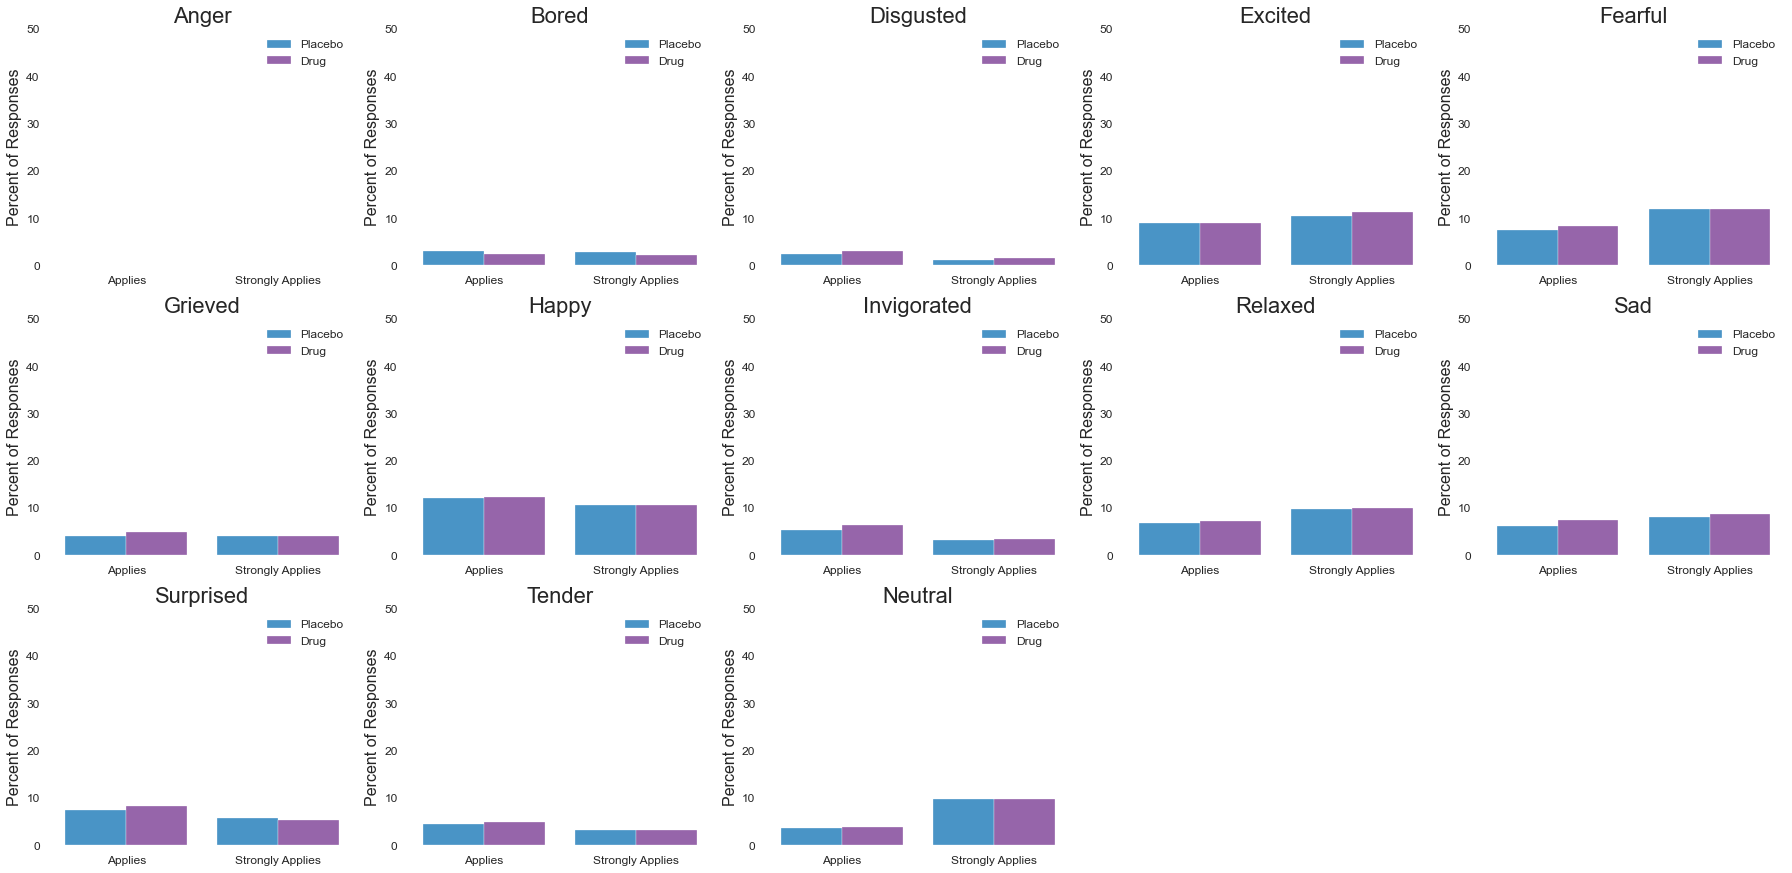

In [133]:
colors = ["#3498db", "#9b59b6"]

plt.figure(figsize=(25,20))
for i, emotion in enumerate(list(perceivedLong['Emotion'].unique())):
    plt.subplot(5, 5, i+1)
    sns.barplot(x="variable", y="value", hue="DrugPlacebo", data=perceivedLong[perceivedLong['Emotion'] == emotion], palette=colors)
    plt.title(emotion, size = 22)
    plt.xlabel('')
    plt.ylabel('Percent of Responses', fontsize=16)
    plt.tight_layout()
    plt.ylim(0, 50)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc = 1, prop={'size': 12})
plt.show()

#### **Conclusions**:
* There doesn't seem to be much of a difference between the placebo and drug conditions. 
* I will not follow up with statistical tests.

### Induced Emotion
#### *Dataframe creation*

In [161]:
cols = list(induced.loc[:, 'Anger':'Neutral'].columns)

placebo = induced[induced['DrugPlacebo']=="Placebo"]
drug = induced[induced['DrugPlacebo']=="Drug"]

#### *Means*

In [165]:
meansI = pd.DataFrame()
meansI['Drug'] = drug[cols].mean().round(2)
meansI['Placebo'] = placebo[cols].mean().round(2)
meansI = meansI.T

#### *Chi-square: Testing whether there is a difference between checked emotions in the drug/placebo conditions*

In [166]:
# drop 0 element (anger)
meansI = meansI.drop(columns = ['Anger'], axis = 1)

chisq, p, dof, expected = chi2_contingency(meansI)
print("chi-sq. = " + str(chisq.round(2)))
print("p = " + str(p.round(5)))
print("degrees of freedom = " + str(dof))
    #degrees of freedom: (rows - 1) * (cols - 1)

chi-sq. = 0.02
p = 1.0
degrees of freedom = 21


#### *Percents*

In [137]:
cols = list(induced.loc[:, 'Anger':'Neutral'].columns)

percentAppliesI = pd.DataFrame()
for column in cols:
    percentAppliesI.loc[column, 'Drug'] = 100 - (len(drug[column].loc[drug[column] == 0])/len(drug)*100)
    percentAppliesI.loc[column, 'Placebo'] = 100 - (len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100)
percentAppliesI.T

Anger    Anxious     Bored  Disgusted    Excited    Fearful  \
Drug       0.0  24.453552  3.825137   4.326047  17.167577  17.896175   
Placebo    0.0  20.168067  4.435107   4.154995  16.246499  18.300654   

          Grieved      Happy  Invigorated     Joyful  Nostalgic   Peaceful  \
Drug     7.331512  19.171220     7.786885  16.985428  11.703097  13.706740   
Placebo  6.255836  18.347339     6.956116  16.059757  12.278245  11.204482   

             Power    Relaxed        Sad  Softhearted  Surprised  Sympathetic  \
Drug     10.200364  14.162113  13.433515     8.788707   6.375228     7.012750   
Placebo   9.103641  11.811391  11.998133     7.889823   4.948646     7.002801   

           Tender  Transcendent    Tension     Wonder    Neutral  
Drug     5.828780      3.051002  17.850638  11.794171  11.520947  
Placebo  5.929038      2.941176  16.293184   9.103641  11.204482

#### *Summary Table*

In [138]:
# make placebo summary table
placeboSummary = pd.DataFrame()
placeboSummary['Sum'] = placebo[cols].sum()
placeboSummary['Mean'] = placebo[cols].mean()
placeboSummary['SD'] = placebo[cols].std()

for column in cols:
    placeboSummary.loc[column, 'Does Not Apply'] = len(placebo[column].loc[placebo[column] == 0])/len(placebo)*100
    placeboSummary.loc[column, 'Applies'] = len(placebo[column].loc[placebo[column] == 1])/len(placebo)*100
    placeboSummary.loc[column, 'Strongly Applies'] = len(placebo[column].loc[placebo[column] == 2])/len(placebo)*100

placeboSummary['DrugPlacebo'] = "Placebo"
placeboSummary['Emotion'] = placeboSummary.index

# make drug summary table
drugSummary = pd.DataFrame()
drugSummary['Sum'] = drug[cols].sum()
drugSummary['Mean'] = drug[cols].mean()
drugSummary['SD'] = drug[cols].std()

for column in cols:
    drugSummary.loc[column, 'Does Not Apply'] = len(drug[column].loc[drug[column] == 0])/len(drug)*100
    drugSummary.loc[column, 'Applies'] = len(drug[column].loc[drug[column] == 1])/len(drug)*100
    drugSummary.loc[column, 'Strongly Applies'] = len(drug[column].loc[drug[column] == 2])/len(drug)*100

drugSummary['DrugPlacebo'] = "Drug"
drugSummary['Emotion'] = drugSummary.index

# rbind
inducedSummary = pd.concat([placeboSummary, drugSummary])
print("inducedSummary shape:", inducedSummary.shape)
print(drugSummary.shape[0] + placeboSummary.shape[0])

#  transform to long format
inducedLong = pd.melt(inducedSummary, id_vars=['Emotion', 'DrugPlacebo', 'Mean', 'SD'], 
                      value_vars=['Applies', 'Strongly Applies'])

inducedLong.sample(5)

inducedSummary shape: (46, 8)
46


Emotion DrugPlacebo      Mean        SD          variable     value
2          Bored     Placebo  0.063025  0.310558           Applies  2.567694
77   Invigorated        Drug  0.099271  0.363706  Strongly Applies  2.140255
65  Transcendent     Placebo  0.036881  0.224687  Strongly Applies  0.746965
83           Sad        Drug  0.198543  0.536349  Strongly Applies  6.420765
51       Fearful     Placebo  0.273576  0.616481  Strongly Applies  9.056956

#### *Plot*

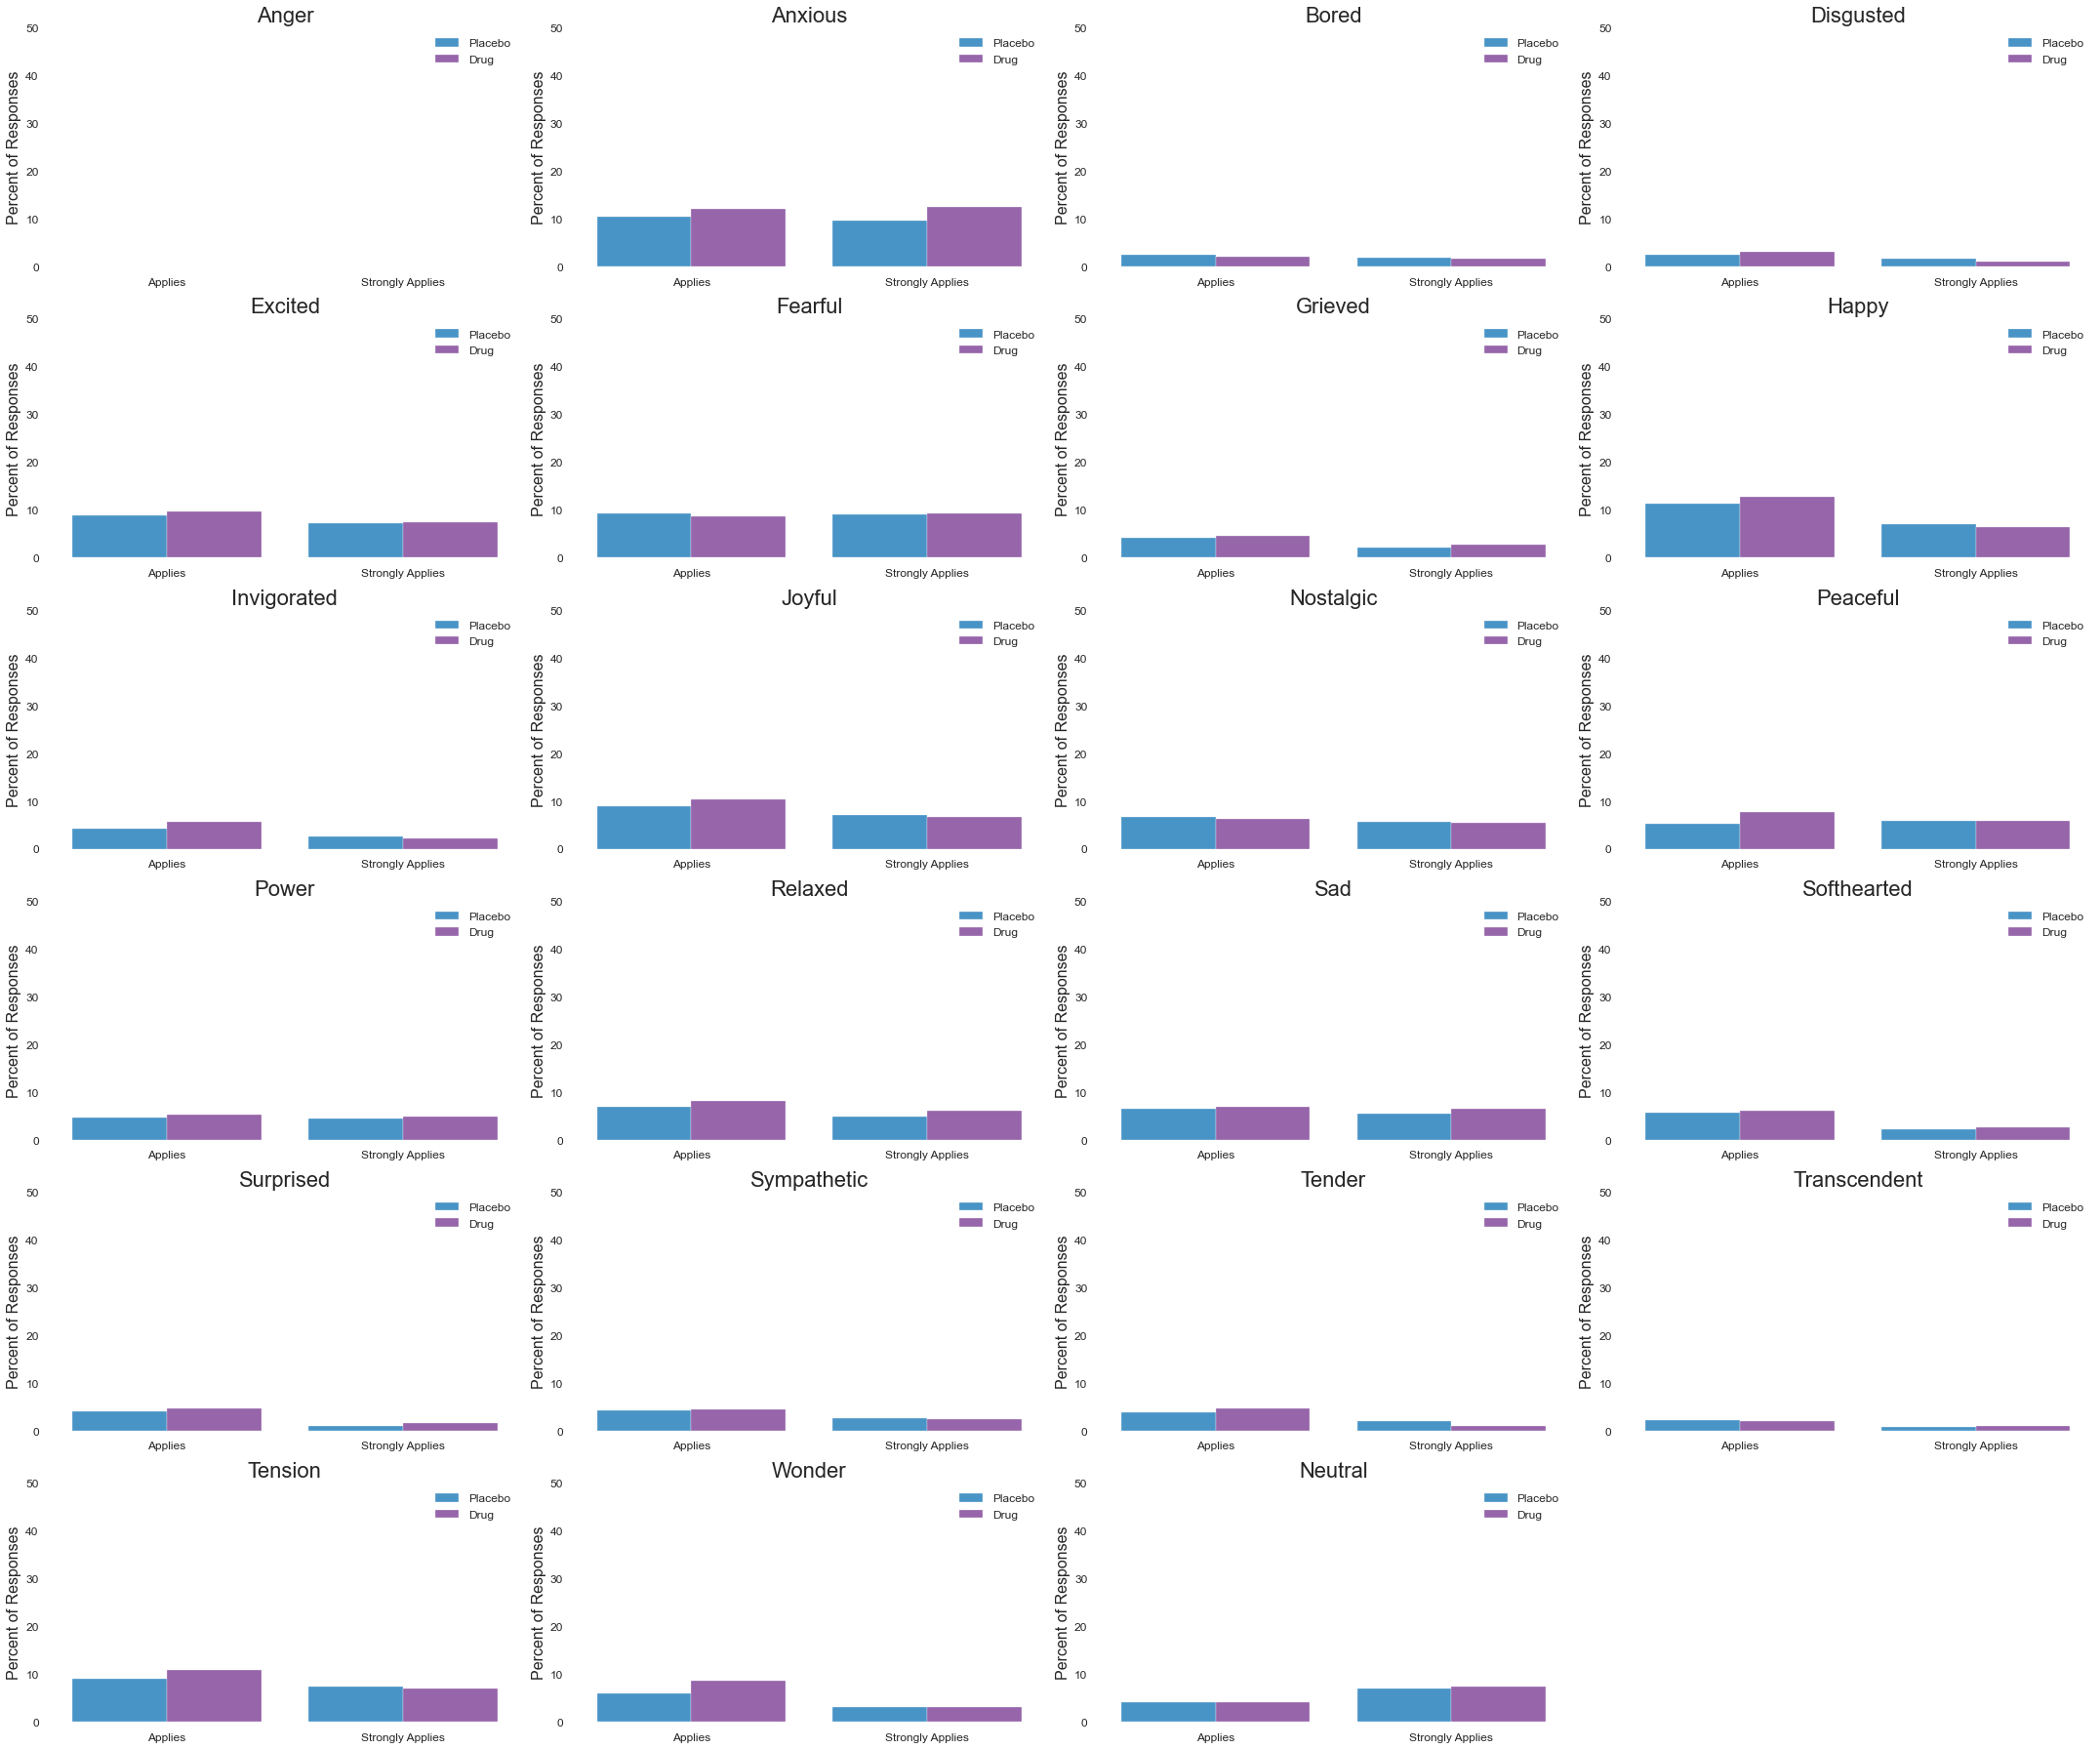

In [139]:
colors = ["#3498db", "#9b59b6"]

plt.figure(figsize=(30,25))
for i, emotion in enumerate(list(inducedLong['Emotion'].unique())):
    plt.subplot(6, 4, i+1)
    sns.barplot(x="variable", y="value", hue="DrugPlacebo", data=inducedLong[inducedLong['Emotion'] == emotion], palette=colors)
    plt.title(emotion, size = 22)
    plt.xlabel('')
    plt.ylabel('Percent of Responses', fontsize=16)
    plt.tight_layout()
    plt.ylim(0, 50)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc = 1, prop={'size': 12})
plt.show()

#### **Conclusions**:
* There doesn't seem to be much of a difference between the placebo and drug conditions. 
* I will not follow up with statistical tests.